In [1]:
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
# from adjustText import adjust_text
from Bio import SeqIO
from Bio.Seq import Seq
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
# %matplotlib notebook
%matplotlib inline

import pickle

from copy import copy

from scipy.spatial import distance

from ast import literal_eval

import gzip
# from cyvcf2 import VCF

%load_ext autoreload
%autoreload 2

import os
import sys

home_dir = '~/Documents/Stanford/Research/EvolvingFront'
home_dir = os.path.expanduser(home_dir)

tools_path = f'{home_dir}/code/processing/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

from itertools import combinations

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

In [2]:
snps = p.read_csv(f'{home_dir}/data/WGS/EvolvingFront_WGS_SNPs_by_sample.csv')

In [3]:
gene_hits = {}

for info in snps['all_information'].values:
    genes_found_here = []
    for mutation in info.split('~'):
    
        if len(mutation.split(':')) == 9:
            (chrom,pos,ref,alt,gene,effect,hgvs_c,hgvs_p,call) =  mutation.split(':')
            if gene not in genes_found_here:
                if gene not in gene_hits:
                    gene_hits[gene] = [f'{effect}:{hgvs_c}:{hgvs_p}:{call}']
                elif f'{effect}:{hgvs_c}:{hgvs_p}:{call}' not in gene_hits[gene]:
                    gene_hits[gene].append(f'{effect}:{hgvs_c}:{hgvs_p}:{call}')
                genes_found_here.append(gene)

gene_hit_count = {gene:len(effects) for gene,effects in gene_hits.items()}

gene_hit_df = p.DataFrame(columns=['gene','count','effects'])
gene_hit_df['gene'] = gene_hit_count.keys()
gene_hit_df['count'] = gene_hit_count.values()
gene_hit_df['effects'] = gene_hits.values()

In [4]:
gene_hit_df.sort_values('count',ascending=False).to_csv(f'{home_dir}/data/WGS/intermediate_files/EvolvingFront_WGS_RepeatHitGenes.csv')

In [5]:
gene_hit_df.sort_values('count',ascending=False)

,gene,count,effects
5,KSP1,68,"[frameshift_variant:c.1529delT:p.Phe510fs:1/1,..."
110,PUF3,28,"[stop_gained:c.1519C>T:p.Gln507*:1/1, stop_gai..."
104,RTG2,15,"[missense_variant:c.989G>T:p.Ser330Ile:1/1, mi..."
161,PAB1,13,"[missense_variant:c.127G>C:p.Gly43Arg:1/1, mis..."
109,CIT1,13,"[missense_variant:c.1307G>T:p.Gly436Val:1/1, m..."
...,...,...,...
165,YNK1,1,[upstream_gene_variant:c.-1469A>T:nan:1/1]
164,tV(AAC)G2,1,[synonymous_variant:c.54G>A:p.Gln18Gln:1/1]
163,CWH43,1,[missense_variant:c.1765G>A:p.Val589Ile:1/1]
159,RQC2,1,[missense_variant:c.2251G>A:p.Glu751Lys:0/1]


In [6]:
genes_sorted = np.asarray(list(gene_hit_count.keys()))[np.argsort(list(gene_hit_count.values()))[::-1]]

In [7]:
ancestral_mutations = {'IRA1_NON':'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1',
                      'IRA1_MIS':'II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1',
                      'CYR1':'X:427906:C:A:CYR1:missense_variant:c.2750C>A:p.Ser917Tyr:1/1',
                      'GPB2':'I:40104:T:G:GPB2:stop_gained:c.846T>G:p.Tyr282*:1/1',
                      'TOR1':'X:564551:T:G:TOR1:missense_variant:c.5136T>G:p.Phe1712Leu:1/1'}

ancestral_mutations = {'IRA1_NON':'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*',
                      'IRA1_MIS':'II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val',
                      'CYR1':'X:427906:C:A:CYR1:missense_variant:c.2750C>A:p.Ser917Tyr',
                      'GPB2':'I:40104:T:G:GPB2:stop_gained:c.846T>G:p.Tyr282*',
                      'TOR1':'X:564551:T:G:TOR1:missense_variant:c.5136T>G:p.Phe1712Leu'}

ancestral_mutations_map = {value:key for key,value in ancestral_mutations.items()}

ancestors = []

mixed_ancestor_calls = []

for sample,info in zip(snps['sample'].values,snps['all_information'].values):
#     mutation_list = all_information.split('~')
    mutation_list = list([':'.join(x.split(':')[:-1]) for x in info.split('~')])
    ancestor = np.nan
    for mutation in mutation_list:
        if mutation in ancestral_mutations_map.keys():
            if not p.isnull(ancestor):
                print(f'uh oh - both {ancestor} and {ancestral_mutations_map[mutation]  }','  removing:',sample)
                mixed_ancestor_calls.append(sample)
                ancestor = np.nan            
            else:
                ancestor = ancestral_mutations_map[mutation]  
#         ancestor = ancestral_mutations_map[mutation]
    ancestors.append(ancestor)

snps['ancestor'] = ancestors
snps = snps[~snps['sample'].isin(mixed_ancestor_calls)]



    

uh oh - both IRA1_NON and CYR1   removing: EvolvingFront_WGS_Plate4_B05
uh oh - both IRA1_NON and CYR1   removing: EvolvingFront_WGS_Plate4_B07
uh oh - both GPB2 and CYR1   removing: EvolvingFront_WGS_Plate4_E02
uh oh - both GPB2 and TOR1   removing: EvolvingFront_WGS_Plate5_C01


In [8]:
cutoff = 2

preexisting_mutations  = {}
preexisting_mutations_genes = {}

for ancestor in ancestral_mutations.keys():
    this_anc = snps[snps['ancestor']==ancestor]
    
    
    
    all_mutations = []
    for info in this_anc['all_information'].values:
        all_mutations += list([':'.join(x.split(':')[:-1]) for x in info.split('~')])
        
    muts,counts = np.unique(all_mutations,return_counts=True)
    pre_ix = np.where(counts>cutoff)[0]
    
    
    preexisting_mutations[ancestor] = [mut for mut in muts[pre_ix] if ':' in mut]
    preexisting_mutations_genes[ancestor] = []
    for m,mut in enumerate(muts[pre_ix]):
        if ':' in mut:
            split = mut.split(':')
            preexisting_mutations_genes[ancestor].append(f'{split[4]}:{split[5]}({counts[pre_ix][m]})')
            
preexisting_mutations_genes['WT'] = []
preexisting_mutations['WT'] = []

In [9]:
preexisting_mutations

{'IRA1_NON': ['II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*',
  'V:510499:G:C:PAB1:missense_variant:c.127G>C:p.Gly43Arg',
  'VI:101127:T:A:YFL021C-A:upstream_gene_variant:c.-4512A>T:nan',
  'VII:1023358:C:A:YGR266W:missense_variant:c.703C>A:p.Gln235Lys',
  'VII:161471:G:C:ATG1:missense_variant:c.1407G>C:p.Leu469Phe',
  'VIII:269744:G:C:KSP1:stop_gained:c.1805C>G:p.Ser602*',
  'VIII:270738:C:T:KSP1:missense_variant:c.811G>A:p.Asp271Asn',
  'XII:1029498:C:A:RPL6B:synonymous_variant:c.261C>A:p.Thr87Thr',
  'XII:122900:AT:A:PUF3:frameshift_variant:c.1814delA:p.Asn605fs',
  'XII:123802:AG:A:PUF3:frameshift_variant:c.912delC:p.Tyr305fs',
  'XII:123802:AG:AGG:PUF3:frameshift_variant:c.911dupC:p.Tyr305fs',
  'XIV:204739:G:A:KEX2:missense_variant:c.2312G>A:p.Ser771Asn',
  'XIV:218512:G:A:ELA1:synonymous_variant:c.151C>T:p.Leu51Leu',
  'XV:608680:G:T:SPP2:missense_variant:c.518C>A:p.Thr173Lys',
  'XV:818647:T:G:RPT4:upstream_gene_variant:c.-4939A>C:nan'],
 'IRA1_MIS': ['II:522697:G:A:IRA1

In [10]:
# These are recurrent mutations in putatively adaptive genes. As such, we want to consider these.
# In addition, 

preexisting_to_ignore = {'IRA1_NON':['VIII:269744:G:C:KSP1:stop_gained:c.1805C>G:p.Ser602*',
                                     'VIII:270738:C:T:KSP1:missense_variant:c.811G>A:p.Asp271Asn',
                                      'V:510499:G:C:PAB1:missense_variant:c.127G>C:p.Gly43Arg',
                                      'XII:122900:AT:A:PUF3:frameshift_variant:c.1814delA:p.Asn605fs',
                                      'XII:123802:AG:A:PUF3:frameshift_variant:c.912delC:p.Tyr305fs',
                                      'XII:123802:AG:AGG:PUF3:frameshift_variant:c.911dupC:p.Tyr305fs'],
                         'IRA1_MIS':['V:142941:CAAT:C:MIT1:disruptive_inframe_deletion:c.1083_1085delTAA:p.Asn362del',
                                     'XIV:467219:A:G:MKT1:missense_variant:c.89A>G:p.Asp30Gly',
                                      'XIV:467219:A:T:MKT1:missense_variant:c.89A>T:p.Asp30Val',
                                    'XIV:631356:ACACAAAAGTATTTTTGGTCTAGCGGGGGTCATACTTTTCATTTCCGGGCGGCTGCGGCGGAAAAAAACGTGACGCCTTTTAG:A:CIT1:upstream_gene_variant:c.-377_-296delCTAAAAGGCGTCACGTTTTTTTCCGCCGCAGCCGCCCGGAAATGAAAAGTATGACCCCCGCTAGACCAAAAATACTTTTGTG:nan',
                                    'V:303524:AT:ATT:TDA2:upstream_gene_variant:c.-1199_-1198insA'],
                         'CYR1':[],
                         'GPB2':[],
                         'TOR1':['X:179445:C:A:PBS2:NON_SYNONYMOUS_CODING:cGt/cTt:R220L']
                        }

for ancestor,preexisting_list in preexisting_mutations.items():
    preexisting_mutations[ancestor] = [mut for mut in preexisting_mutations[ancestor] if mut not in preexisting_to_ignore[ancestor]]

In [11]:
def mutation_zygosity(call):
    
    if (call == '0/1') or (call == '0|1'):
        return 'HET'
    elif (call == '1/1') or (call == '1|1') or (call=='1'):
        return 'HOM'

In [12]:
### Manually reclassify a few mutants that are likely associated with something else

mutants_to_reclassify = {'VI:101127:T:A:YFL021C-A:upstream_gene_variant:c.-4512A>T:nan':
 'VI:101127:T:A:LPD1:downstream_gene_variant:c.*501A>T:nan', ## closer "named" gene, consistency with Aggeli 2021
 
 ### appears to be upstream modifier of CIT1
 'XIV:631356:ACACAAAAGTATTTTTGGTCTAGCGGGGGTCATACTTTTCATTTCCGGGCGGCTGCGGCGGAAAAAAACGTGACGCCTTTTAG:A:YNR001W-A:frameshift_variant:c.102_183delGTATTTTTGGTCTAGCGGGGGTCATACTTTTCATTTCCGGGCGGCTGCGGCGGAAAAAAACGTGACGCCTTTTAGCACAAAA:p.Tyr35fs':
 'XIV:631356:ACACAAAAGTATTTTTGGTCTAGCGGGGGTCATACTTTTCATTTCCGGGCGGCTGCGGCGGAAAAAAACGTGACGCCTTTTAG:A:CIT1:upstream_gene_variant:c.-377_-296delCTAAAAGGCGTCACGTTTTTTTCCGCCGCAGCCGCCCGGAAATGAAAAGTATGACCCCCGCTAGACCAAAAATACTTTTGTG:nan',
 
### also appears to be upstream modifier of CIT1
'XIV:631351:C:T:YNR001W-A:missense_variant:c.89C>T:p.Pro30Leu':
'XIV:631351:C:T:CIT1:upstream_gene_variant:c.-290G>A:nan',
 
 ### others of question: RPL7, PET8? both downstream of CIT1...
                         
                         
 ### appears to be upstream modifier of ALD5
    'V:303524:AT:ATT:TDA2:upstream_gene_variant:c.-1199_-1198insA:nan':
    'V:303524:AT:ATT:ALD5:upstream_gene_variant:c.-505_-504insT:nan',
                         
    'V:303524:AT:A:TDA2:upstream_gene_variant:c.-1198delA:nan':
    'V:303524:AT:A:ALD5:upstream_gene_variant:c.-505delT:nan',
}

new_muts = []
new_info = []
for muts,info in zip(snps['mutations'].values,snps['all_information'].values):
    info_here = copy(info)
    for original,new in mutants_to_reclassify.items():
        if original in info:
            info_here = copy(info.replace(original,new))

    muts_here = []
    for variant in info_here.split('~'):
        split = variant.split(':')
        muts_here.append(f'{split[4]}:{split[5]}:{mutation_zygosity(split[-1])}')      
            
    new_info.append(info_here)
    new_muts.append(copy(muts_here))
            
                    
snps['mutations'] = new_muts
snps['all_information'] = new_info


In [13]:
ploidy_calls = p.read_csv(f'{home_dir}/data/BenomylTest/EvolvingFront_rearray_map_with_ploidy.csv')
wgs_identified_barcodes = p.read_csv(f'{home_dir}/data/WGS/intermediate_files/EvolvingFront_WGS_allExtractedBCs.csv')
sequencing_map = p.read_csv(f'{home_dir}/data/WGS/intermediate_files/sequencing_maps/EvolvingFront_Sequencing_list.csv')
plate5_map = p.read_csv(f'{home_dir}/data/WGS/intermediate_files/EvolvingFront_WGS_Plate5_map.csv')

additions = p.DataFrame([['EVO3D_TCG_rearray_Plate1-G11','EvolvingFront_Sequencing_Plate4-E11','CCGCCAATCCCGAACCCCGTTTCGCC_TATGCAAGACACAACATGCTTTTAAT'],
                                       ['EVO3D_TCG_rearray_Plate1-G12','EvolvingFront_Sequencing_Plate4-E12','GACAGAAAAGCCAAATGGATTTACCG_AGCATAATAGCTAAGAGTATTTACTA']],
                                      columns=['source_well','destination_well','barcode'])

sequencing_map = p.concat([sequencing_map,additions])

### replace sequencing samples with Plate5 instead of old name
new_dest_wells = []
for old_plate in sequencing_map['destination_well'].values:
    old_name = old_plate.replace('EvolvingFront_Sequencing_','')
    if old_name in plate5_map['oldplate_name'].values:
        new_name = plate5_map[plate5_map['oldplate_name']==old_name]['Well'].values[0]
        new_dest_wells.append(f'EvolvingFront_Sequencing_{new_name}')
#         print(old_name,new_name)
    else:
        new_dest_wells.append(f'EvolvingFront_Sequencing_{old_name}')
sequencing_map['destination_well'] = new_dest_wells

print(sequencing_map['destination_well'])

dests_renamed = []
for plate in sequencing_map['destination_well'].values:
    prefix = plate.split('-')[0]
    row = plate.split('-')[1][0]
    col = plate.split('-')[1][1:]
    
#     print(prefix,row,col)
    dests_renamed.append(f"{prefix.replace('Sequencing','WGS')}_{row}{int(col):02}")
sequencing_map['destination_well_renamed'] = dests_renamed


source_names = []
intended_bcs = []
oriented_barcodes = []

files_for_removal = []

for entry,barcode in zip(wgs_identified_barcodes['file_prefix'].values,wgs_identified_barcodes['doubleBC'].values):
    
    if 'rearray' in entry:
#         source_well = 
        
        source_names.append(entry)
        intended_bcs.append(ploidy_calls[ploidy_calls['destination_well']==entry]['barcode'].values[0])
        oriented_barcodes.append(f"{barcode.split('_')[1]}_{barcode.split('_')[0]}")
    else:
        if entry in sequencing_map['destination_well_renamed'].values:
            source_well = sequencing_map[sequencing_map['destination_well_renamed']==entry]['source_well'].values[0] 
            source_names.append(source_well)

            intended_bcs.append(sequencing_map[sequencing_map['destination_well_renamed']==entry]['barcode'].values[0])
            oriented_barcodes.append(f"{barcode.split('_')[1]}_{barcode.split('_')[0]}")
        else:
#             print(entry)
            files_for_removal.append(entry)
            
wgs_identified_barcodes = wgs_identified_barcodes[~wgs_identified_barcodes['file_prefix'].isin(files_for_removal)]
            
wgs_identified_barcodes['source_name'] = source_names
wgs_identified_barcodes['intendedBC'] = intended_bcs
wgs_identified_barcodes['observedBC'] = oriented_barcodes


0       EvolvingFront_Sequencing_Plate1-A1
1       EvolvingFront_Sequencing_Plate1-A2
2       EvolvingFront_Sequencing_Plate1-A3
3       EvolvingFront_Sequencing_Plate5-A1
4       EvolvingFront_Sequencing_Plate1-A5
                      ...                 
343     EvolvingFront_Sequencing_Plate4-E8
344     EvolvingFront_Sequencing_Plate4-E9
345    EvolvingFront_Sequencing_Plate4-E10
0      EvolvingFront_Sequencing_Plate4-E11
1      EvolvingFront_Sequencing_Plate4-E12
Name: destination_well, Length: 348, dtype: object


In [14]:
wgs_identified_barcodes.to_csv(f'{home_dir}/data/WGS/intermediate_files/EvolvingFront_WGS_IdentifiedBarcodes.csv',index=False)

In [15]:
snps['file_prefix'] = snps['sample']

In [16]:
snps_plus_bcs = p.merge(wgs_identified_barcodes,snps,on='file_prefix')

# new column without ancestral mutations (+ call ancestral mutations??)

In [17]:
# mutations_in_ancestor = {}

# for ancestor in list(ancestral_mutations.keys()):
#     this_anc = snps_plus_bcs[snps_plus_bcs['ancestor']==ancestor]
    
#     mutations_here = []
    
#     for info in this_anc['all_information'].values:
#         mutations_here += info.split('~')
        
#     unique_mutations,unique_counts = np.unique(mutations_here,return_counts=True)
    
#     multi_muts = unique_mutations[np.where(unique_counts>1)[0]]
#     multi_counts = unique_counts[np.where(unique_counts>1)[0]]
    
#     for mut,count in zip(multi_muts[np.argsort(multi_counts)[::-1]],multi_counts[np.argsort(multi_counts)[::-1]]):
#         print('\n')
#         print(mut,count)
#         for (sample,bc,mutations,info) in zip(this_anc['sample'].values,this_anc['observedBC'].values,
#                                           this_anc['mutations'].values,this_anc['all_information'].values):
#             if mut in info:
#                 print(sample,bc)
        


In [18]:
matches = 0
mismatches = 0
no_bc = 0

mismatch_list = []

for source,seq_name,intended,observed in wgs_identified_barcodes[['source_name','file_prefix','intendedBC','observedBC']].values:
    if observed != '_':
        if intended != observed:
            print('REMOVING MISMATCH!',source,seq_name,intended,observed)
            
            mismatch_list.append(intended)
            mismatches += 1
        else:
            matches += 1
    else: 
        no_bc += 1
#         print('\t','no bc',seq_name,intended)
        
print(matches,mismatches,no_bc,matches+mismatches+no_bc)

wgs_identified_barcodes = wgs_identified_barcodes[~wgs_identified_barcodes['intendedBC'].isin(mismatch_list)]

REMOVING MISMATCH! EVO3D_IRA1_NON_rearray_Plate2-C12 EvolvingFront_WGS_Plate4_B02 ATCACAATAACTAAACTGATTCTTCA_CTCATAACATCAAAAAAAATTCAAAT ATCACAATAACTAAACTGATTCTTCA_GAATTAATTAGAAAGGGGATTAAGCG
REMOVING MISMATCH! EVO3D_IRA1_NON_rearray_Plate2-D8 EvolvingFront_WGS_Plate4_B03 ATCACAATAACTAAACTGATTCTTCA_TAGTAAATCTCGAAAAAATTTACAAT ATCACAATAACTAAACTGATTCTTCA_TTTTAAATGACTAAGTAAATTCTCCT
324 2 35 361


In [19]:
conditions = ['Fit1D-2%','Fit1D-5%',
              'Fit2D-2%','Fit2D-5%',
              'Fit3D-2%','Fit3D-5%',
              'Fit5D-2%','Fit5D-5%']

# replicates = [1,2,3]
replicates = {'Fit1D-2%':[1,2],
              'Fit1D-5%':[1,2],
              'Fit2D-2%':[1,2],
              'Fit2D-5%':[1,2],
              'Fit3D-2%':[1,2,3],
              'Fit3D-5%':[1,2,3],
              'Fit5D-2%':[1,2,3],
              'Fit5D-5%':[1,2,3]}

timepoints = {'Fit1D-2%':7,
              'Fit1D-5%':7,
              'Fit2D-2%':7,
              'Fit2D-5%':7,
              'Fit3D-2%':3,
              'Fit3D-5%':3,
              'Fit5D-2%':3,
              'Fit5D-5%':3}

In [20]:
merged_fitness = p.read_csv(f'{home_dir}/data/EvolvingFront_2%5%FitnessMeasurementData.csv')
time_fitness = p.read_csv(f'{home_dir}/data/EvolvingFront_2%5%FitnessMeasurementData_fitnessByTime.csv')
aggeli_variants = p.read_excel(f'{home_dir}/data/WGS/Aggeli_et_al_2021/GWS_Fit.xlsx',sheet_name='Variants')
aggeli_commonvariants = p.read_excel(f'{home_dir}/data/WGS/Aggeli_et_al_2021/GWS_Fit.xlsx',sheet_name='CommonVariants')

In [21]:
full_cloneID_list = []
full_ploidy_list = []
evo_cond_list = []
anc_list = []
mutation_list = []
mutation_list_verbose = []

for barcode,cloneID,source,ploidy,evo_cond,anc,gene,mut_type,additional_muts in zip(merged_fitness['barcode'].values,
                                         merged_fitness['cloneID'].values,
                                         merged_fitness['source_publication'].values,
                                         merged_fitness['ploidy'].values,
                                         merged_fitness['evolution_condition'].values,
                                         merged_fitness['ancestor'].values,
                                         merged_fitness['gene'].values,
                                         merged_fitness['type'].values,
                                         merged_fitness['additional_muts'].values):
    if source == 'This_study':
        
        this_bc = ploidy_calls[ploidy_calls['barcode']==barcode]
        this_id = np.nan
        if len(this_bc) == 0:
            this_id = np.nan
            full_cloneID_list.append(np.nan)
            full_ploidy_list.append('?')
#             mutation_list.append(np.nan)
        elif len(this_bc) > 1:
#             print('hmm... more that one found')
#             print(this_bc)
            full_cloneID_list.append(this_bc['destination_well'].values[0])
            full_ploidy_list.append(this_bc['ploidy'].values[0])
            this_id = this_bc['destination_well'].values[0]
            
        else:
            full_cloneID_list.append(this_bc['destination_well'].values[0])
            full_ploidy_list.append(this_bc['ploidy'].values[0])
            this_id = this_bc['destination_well'].values[0]
            

        bc_low_complexity = barcode.split('_')[0]
        
        entry = tools.new_lowcomplexity_bc_to_entry_dict[bc_low_complexity]
        
        if 'IRA1_NON' in entry:
            anc_list.append('IRA1_NON')
        elif 'IRA1_MIS' in entry:
            anc_list.append('IRA1_MIS')
        elif entry in ['TOR1','CYR1','GPB2']:
            anc_list.append(entry)
            entry = this_id
            
        if not p.isnull(entry):
            if 'EVO1D' in entry:
                evo_cond_list.append('Evo1D')
            elif 'EVO2D' in entry:
                evo_cond_list.append('Evo2D')
            elif 'EVO3D' in entry:
                evo_cond_list.append('Evo3D')
            else:
                evo_cond_list.append('unknown')
        else:
            evo_cond_list.append('unknown')
        if this_id in sequencing_map['source_well'].values:

            seq_well = sequencing_map[sequencing_map['source_well']==this_id]['destination_well_renamed'].values[0]
            if seq_well in snps['sample'].values:
#                 mutation_list.append(str(snps[snps['sample']==seq_well]['mutations'].values[0]))
                mutation_list_verbose.append(str(snps[snps['sample']==seq_well]['all_information'].values[0]))
                
                variants = str(snps[snps['sample']==seq_well]['all_information'].values[0]).split('~')
                muts_here = []
                for variant in variants:
                    split = variant.split(':')
                    muts_here.append(f'{split[4]}:{split[5]}:{mutation_zygosity(split[-1])}')      
            
                mutation_list.append(muts_here)
                
            elif this_id in snps['sample'].values:
                mutation_list_verbose.append(snps[snps['sample']==this_id]['all_information'].values[0])

                variants = str(snps[snps['sample']==this_id]['all_information'].values[0]).split('~')
                muts_here = []
                for variant in variants:
                    split = variant.split(':')
                    muts_here.append(f'{split[4]}:{split[5]}:{mutation_zygosity(split[-1])}')  
                    
                mutation_list.append(muts_here)
                
            else:
                mutation_list.append(np.nan)
                mutation_list_verbose.append(np.nan)
        else:
            mutation_list.append(np.nan)
            mutation_list_verbose.append(np.nan)
    
    elif source == 'Aggeli2020':
        full_cloneID_list.append(cloneID)
        full_ploidy_list.append(ploidy)
        evo_cond_list.append(evo_cond)
        anc_list.append(anc)
        
        this_calls = aggeli_variants[aggeli_variants['low_high']==barcode]
        this_common_calls = aggeli_commonvariants[aggeli_commonvariants['GWS_Bar']==barcode]
        
        variants = []
        
        for entries in this_calls[['CHROM','POS','REF','ALT','GENE','EFFECT','CODON_CHANGE','AMINO_ACID_CHANGE','GT']].values:
            variants.append(':'.join([str(x) for x in entries]))
        for entries in this_common_calls[['CHROM','POS','REF','ALT','GENE','EFFECT','CODON_CHANGE','AMINO_ACID_CHANGE','GT']].values:
            variants.append(':'.join([str(x) for x in entries]))  
            
        variants = list(np.unique(variants))
        
        if len(variants) > 0: 
            mutation_list_verbose.append('~'.join(variants))
            muts_here = []
            for variant in variants:
                split = variant.split(':')
                muts_here.append(f'{split[4]}:{split[5]}:{mutation_zygosity(split[-1])}')      
            
            mutation_list.append(muts_here)
            
        elif gene not in [np.nan,'None','NotSequenced','other']:
            mutation_list.append(f'{gene}-{mut_type}; {additional_muts}')
            mutation_list_verbose.append(np.nan)
        elif not p.isnull(gene):
            mutation_list.append(f'{additional_muts}')
            mutation_list_verbose.append(np.nan)
        else:
            mutation_list.append(np.nan)
            mutation_list_verbose.append(np.nan)
    
    
    
    else:

        full_cloneID_list.append(cloneID)
        full_ploidy_list.append(ploidy)
        evo_cond_list.append(evo_cond)
        anc_list.append(anc)
        mutation_list_verbose.append(np.nan)
        if gene not in [np.nan,'None','NotSequenced','other']:
            mutation_list.append(f'{gene}-{mut_type}; {additional_muts}')
        elif not p.isnull(gene):
            mutation_list.append(f'{additional_muts}')
        else:
            mutation_list.append(np.nan)
        
merged_fitness['cloneID_new'] = full_cloneID_list
merged_fitness['ploidy_new'] = full_ploidy_list
merged_fitness['evolution_condition'] = evo_cond_list
merged_fitness['ancestor'] = anc_list
merged_fitness['all_mutations'] = mutation_list
merged_fitness['all_mutations_verbose'] = mutation_list_verbose

In [22]:
### Add some Aggeli mutants to pre-existing list
preexisting_mutations['GPB2'].append('I:40104:T:G:GPB2:STOP_GAINED:taT/taG:Y282*') # ancestral 
preexisting_mutations['GPB2'].append('VI:101127:T:A:LPD1:DOWNSTREAM:501:nan')
preexisting_mutations['GPB2'].append('VI:58065:C:A:TUB2:DOWNSTREAM:356:nan')
preexisting_mutations['GPB2'].append('IV:1170535:C:T:YDR348C:NON_SYNONYMOUS_CODING:Gtt/Att:V431I')

preexisting_mutations['CYR1'].append('X:427906:C:A:CYR1:NON_SYNONYMOUS_CODING:tCt/tAt:S917Y') # ancestral
preexisting_mutations['CYR1'].append('XVI:940751:T:G:ARR3:NON_SYNONYMOUS_CODING:aTt/aGt:I277S')
preexisting_mutations['CYR1'].append('II:632333:G:C:LDH1:NON_SYNONYMOUS_CODING:tCt/tGt:S350C')
preexisting_mutations['CYR1'].append('XIII:23476:G:GA:PHO84:DOWNSTREAM:560:nan')

preexisting_mutations['TOR1'].append('X:564551:T:G:TOR1:NON_SYNONYMOUS_CODING:ttT/ttG:F1712L') # ancestral
preexisting_mutations['TOR1'].append('VIII:362075:C:A:FUR1:UPSTREAM:40:nan')
preexisting_mutations['TOR1'].append('XIV:103969:A:G:MRPL10:NON_SYNONYMOUS_CODING:tTc/tCc:F45S')
preexisting_mutations['TOR1'].append('VII:961959:T:G:MOS2:NON_SYNONYMOUS_CODING:Aat/Cat:N35H')
preexisting_mutations['TOR1'].append('XIV:553379:C:G:YNL040W:UPSTREAM:1:nan')
preexisting_mutations['TOR1'].append('X:179445:C:A:PBS2:NON_SYNONYMOUS_CODING:cGt/cTt:R220L')

for anc,muts in preexisting_mutations.items():
    new_list = []
    for mut in muts:
        for original,new in mutants_to_reclassify.items():
            if original in mut:
                new_list.append(mut.replace(original,new))
                break
        else:
            new_list.append(mut)
    preexisting_mutations[anc] = new_list  
    
for ancestor,preexisting_list in preexisting_mutations.items():
    preexisting_mutations[ancestor] = [mut for mut in preexisting_mutations[ancestor] if mut not in preexisting_to_ignore[ancestor]]
                
with open(f'{home_dir}/data/intermediate/preexisting_mutations.pkl', 'wb') as f:
    pickle.dump(preexisting_mutations, f)


ancestral_mutations_aggeli_format = {'CYR1':'X:427906:C:A:CYR1:NON_SYNONYMOUS_CODING:tCt/tAt:S917Y',
                                     'GPB2':'I:40104:T:G:GPB2:STOP_GAINED:taT/taG:Y282*',
                                    'TOR1':'X:564551:T:G:TOR1:NON_SYNONYMOUS_CODING:ttT/ttG:F1712L',
                                     'IRA1_MIS':'','IRA1_NON':''}
# ancestral_mutations_aggeli['GPB2']

In [23]:
preexisting_mutations

{'IRA1_NON': ['II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*',
  'VI:101127:T:A:LPD1:downstream_gene_variant:c.*501A>T:nan',
  'VII:1023358:C:A:YGR266W:missense_variant:c.703C>A:p.Gln235Lys',
  'VII:161471:G:C:ATG1:missense_variant:c.1407G>C:p.Leu469Phe',
  'XII:1029498:C:A:RPL6B:synonymous_variant:c.261C>A:p.Thr87Thr',
  'XIV:204739:G:A:KEX2:missense_variant:c.2312G>A:p.Ser771Asn',
  'XIV:218512:G:A:ELA1:synonymous_variant:c.151C>T:p.Leu51Leu',
  'XV:608680:G:T:SPP2:missense_variant:c.518C>A:p.Thr173Lys',
  'XV:818647:T:G:RPT4:upstream_gene_variant:c.-4939A>C:nan'],
 'IRA1_MIS': ['II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val',
  'V:177308:C:A:YER010C:upstream_gene_variant:c.-3970G>T:nan',
  'V:303524:AT:ATT:ALD5:upstream_gene_variant:c.-505_-504insT:nan',
  'XI:347074:C:T:YKL050C:upstream_gene_variant:c.-1454G>A:nan',
  'XV:87280:AT:A:MDH2:upstream_gene_variant:c.-4361delA:nan'],
 'CYR1': ['II:610499:A:T:MED8:upstream_gene_variant:c.-746T>A:nan',
  'X:427906:C:A:CY

In [24]:
### call putative causal genes, categorize them under "gene" organize other mutations

gene_hits = {}
gene_hits_samples = {}
gene_hit_count = {}


for ancestor in ancestral_mutations.keys():
    this_anc = merged_fitness[merged_fitness['ancestor']==ancestor]
    
    gene_hits[ancestor] = {}
    gene_hits_samples[ancestor] = {}

    for mutations_verbose in this_anc['all_mutations_verbose'].values:
        if not p.isnull(mutations_verbose):
            variants = mutations_verbose.split('~')
            genes_in_sample = []
            for variant in variants:
                for pre_existing in preexisting_mutations[ancestor]:
                    if pre_existing in variant:
                        break
                else: # if it's not a pre-existing mutation
                    gene = variant.split(':')[4]
                    if gene not in genes_in_sample:
                        if gene not in gene_hits[ancestor]:
                            gene_hits[ancestor][gene] = [variant]
                            gene_hits_samples[ancestor][gene] = [sample]
                        else:
                            if variant not in gene_hits[ancestor][gene]:
                                gene_hits[ancestor][gene].append(variant)
                                gene_hits_samples[ancestor][gene].append(sample)
                        genes_in_sample.append(gene)

    gene_hit_count[ancestor] = {gene:len(effects) for gene,effects in gene_hits[ancestor].items()}                   


In [25]:
gene_hit_anc_df = p.DataFrame(columns=['ancestor','gene','count','effects','samples'])

gene_list = []
count_list = []
effect_list = []
anc_list = []
sample_list = []

for ancestor in ancestral_mutations.keys():
    gene_list += gene_hit_count[ancestor].keys()
    count_list += (gene_hit_count[ancestor].values())
    effect_list += gene_hits[ancestor].values()
    anc_list += [ancestor] * len(gene_hit_count[ancestor].keys())
    sample_list += gene_hits_samples[ancestor].values()

gene_hit_anc_df['ancestor'] = anc_list
gene_hit_anc_df['gene'] = gene_list
gene_hit_anc_df['count'] =  count_list
gene_hit_anc_df['effects'] = effect_list
gene_hit_anc_df['samples'] = sample_list


gene_hit_anc_df.to_csv(f'{home_dir}/data/WGS/intermediate_files/EvolvingFront_WGS_RepeatHitGenes_byAncestor.csv')



In [26]:
all_ancs = gene_hit_anc_df.groupby('gene',as_index=False).sum()

sorted_all = all_ancs[all_ancs['count']>1].sort_values(['count','gene'],ascending=[False,True])
# sorted_all = all_ancs.sort_values(['count','gene'],ascending=[False,True])

count_matrix = np.zeros((len(ancestral_mutations.keys())+1,len(sorted_all)))

count_matrix[0,:] = sorted_all['count'].values

for a,ancestor in enumerate(ancestral_mutations.keys()):
    for g,gene in enumerate(sorted_all['gene'].values):
        this_gene_anc = gene_hit_anc_df[(gene_hit_anc_df['gene']==gene) & (gene_hit_anc_df['ancestor']==ancestor)]
        if len(this_gene_anc) == 1:
            count_matrix[a+1,g] = this_gene_anc['count'].values[0]

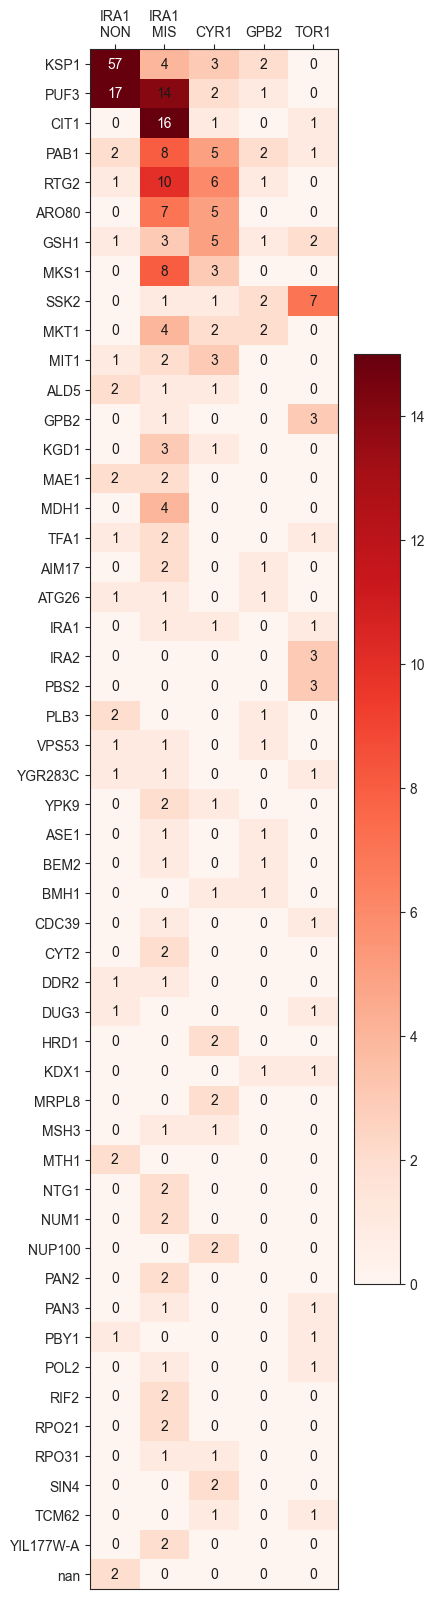

In [27]:
plt.figure(figsize=(4,20))
plt.pcolormesh(count_matrix[1:,:].swapaxes(0,1),cmap='Reds',vmin=0,vmax=15)
plt.colorbar()
# plt.cmap()
# plt.yticks([x+0.5 for x in range(len(ancestral_mutations.keys())+1)],['All']+list(ancestral_mutations.keys()))
plt.xticks([x+0.5 for x in range(len(ancestral_mutations.keys()))],[item.replace('_','\n') for item in list(ancestral_mutations.keys())])
plt.yticks([x+0.5 for x in range(len(sorted_all['gene'].values))],list(sorted_all['gene'].values))

for a in range(len(ancestral_mutations.keys())):
    for g in range(len(sorted_all['gene'].values)):
        text_color='k'
        if count_matrix[a+1,g] > 15:
            text_color = 'w'
        
        plt.text(x=a+0.5,y=g+0.5,s=f'{int(count_matrix[a+1,g])}',ha='center',va='center',color=text_color)

plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.savefig(f'{home_dir}/figures/analysis/mutations/WGS_GeneHits_byAncestor_Matrix.pdf',bbox_inches='tight')
# plt.savefig(f'{home_dir}/plots/WGS_GeneHits_byAncestor_Matrix.pdf',bbox_inches='tight')

In [28]:
# let's call genes with at least 3 unique mutations across all sequenced samples "putatively causal"

putative_causal_genes = list(all_ancs[all_ancs['count']>=3].sort_values(['count','gene'],ascending=[False,True])['gene'].values)


## 

manual_removal_genes = ['YGR283C','MIT1'] # Both not real

putative_causal_genes = [gene for gene in putative_causal_genes if gene not in manual_removal_genes]


### manually add in some more genes, based on overlap of commonly hit pathways

manual_putative_additions = [
    'BMH1', # involved in RTG pathway
    'BMH2', # involved in RTG pathway
    'GPR1', # involved in Ras/PKA pathway
    'PAN2', # involved in deadenylation, interacts with PAB1
    'PAN3', # involved in deadenylation, interacts with PAB1
    'SCH9',
    'RAS2',
    'YAK1',
    'TFS1',
    'GPB1',
    'MDH2',
    'HOG1',
    'PBS2',
    'MTH1', # related to glucose-senseing
    
]

putative_causal_genes += manual_putative_additions





causal_genes = []
causal_effect = []
other_genes = []
for ancestor,gene,all_mutations_verbose,all_mutations in zip(merged_fitness['ancestor'].values,
                                                             merged_fitness['gene'].values,
                                                             merged_fitness['all_mutations_verbose'].values,
                                                             merged_fitness['all_mutations'].values):
    
    if ancestor != 'WT':
        this_causal = []
        this_effect = []
        this_other = []
        if not p.isnull(all_mutations_verbose):
            variants = all_mutations_verbose.split('~')
            for variant in variants:
                split = variant.split(':')
                gene = split[4]
                effect = split[5]
                for pre in preexisting_mutations[ancestor]:
                    if pre in variant:
                        if (pre not in ancestral_mutations[ancestor]) and (pre not in ancestral_mutations_aggeli_format[ancestor]):
                            this_other.append(f'{gene}-{effect}')
                        break
                else:
                    if gene in putative_causal_genes:
                        if gene not in this_causal:
                            this_causal.append(gene)
                            this_effect.append(effect)
                        else:
                            loc = np.where(np.isin(this_causal,gene))[0][0]
                            this_effect[loc] = this_effect[loc]+effect
                    else:
                        this_other.append(f'{gene}-{effect}')

            causal_genes.append('+'.join(this_causal))
            causal_effect.append('+'.join(this_effect))
            other_genes.append(this_other)
        else:
            causal_genes.append(np.nan)
            causal_effect.append(np.nan)
            other_genes.append(np.nan)
                    
     
        
    else:
        causal_genes.append(gene)
        causal_effect.append(np.nan)
        other_genes.append(all_mutations)

merged_fitness['gene'] = causal_genes
merged_fitness['effect'] = causal_effect
merged_fitness['other_genes'] = other_genes


In [29]:
new_conditions = {'Fit1D_both2%5%':['Fit1D-2%','Fit1D-5%'],
                 'Fit2D_both2%5%':['Fit2D-2%','Fit2D-5%'],
                 'Fit3D_both2%5%':['Fit3D-2%','Fit3D-5%'],
                 'Fit5D_both2%5%':['Fit5D-2%','Fit5D-5%']}


for new_condition,old_conditions in new_conditions.items():
    
    new_fitness, new_error = tools.inverse_variance_mean(merged_fitness[[f'{condition}_fitness' for condition in old_conditions]].values,
                                                   merged_fitness[[f'{condition}_error' for condition in old_conditions]].values)
    
    merged_fitness[f'{new_condition}_fitness'] = new_fitness
    merged_fitness[f'{new_condition}_error'] = new_error
    
    new_fitness_li, new_error_li = tools.inverse_variance_mean(merged_fitness[[f'{condition}_fitness_Li2019Neutrals' for condition in old_conditions]].values,
                                                   merged_fitness[[f'{condition}_error_Li2019Neutrals' for condition in old_conditions]].values)
  
    merged_fitness[f'{new_condition}_fitness_Li2019Neutrals'] = new_fitness_li
        
    merged_fitness[f'{new_condition}_error_Li2019Neutrals'] = new_error_li



In [30]:
early_timepoints = [0]

early_conditions = {'Fit2D':['Fit2D-2%_R1','Fit2D-2%_R2','Fit2D-5%_R1','Fit2D-5%_R2'],
                    'Fit3D':['Fit3D-2%_R1','Fit3D-2%_R2','Fit3D-2%_R3','Fit3D-5%_R1','Fit3D-5%_R2','Fit3D-5%_R3'],
                    'Fit5D':['Fit5D-2%_R1','Fit5D-2%_R2','Fit5D-2%_R3','Fit5D-5%_R1','Fit5D-5%_R2','Fit5D-5%_R3']
                   }

for condition,reps in early_conditions.items():
    early_intervals = [f'{rep}_T{t}' for rep in reps for t in early_timepoints]
    early_fitness,early_error = tools.inverse_variance_mean(time_fitness[early_intervals].values,
                                                 time_fitness[[x+'_error' for x in early_intervals]].values)
    

    merged_fitness[f'{condition}_early_fitness'] = early_fitness
    merged_fitness[f'{condition}_early_error'] = early_error

In [31]:
merged_fitness['Fit2D_early-Fit1D_both2%5%_fitness'] =  merged_fitness['Fit2D_early_fitness'] - merged_fitness['Fit1D_both2%5%_fitness']
merged_fitness['Fit2D_early-Fit1D_both2%5%_error'] = merged_fitness['Fit2D_early_error'] + merged_fitness['Fit1D_both2%5%_error']

merged_fitness['Fit5D_early-Fit3D_early_fitness'] =  (merged_fitness['Fit2D_early_fitness'] - merged_fitness['Fit1D_both2%5%_fitness'])/2
merged_fitness['Fit5D_early-Fit3D_early_error'] = (merged_fitness['Fit2D_early_error'] + merged_fitness['Fit1D_both2%5%_error'])/(2**2)

In [32]:
# oneday_vals_inorder = merged_fitness[[x+'_fitness' for x in np.random.permutation(oneday_options)]].values
# twoday_vals_inorder = time_fitness[np.random.permutation(twoday_options)].values

# resp_ests = (twoday_order.values-oneday_order.values)/24

### Calculate Performances from early fitnesses

# resp_1Day = ['Fit1D-2%-R1','Fit1D-5%-R1','Fit1D-2%-R2','Fit1D-5%-R2']
resp_1Day = ['Fit1D-2%-R2','Fit1D-5%-R2']
# resp_1Day = ['Fit1D-2%-R1','Fit1D-5%-R1']
resp_2Day = ['Fit2D-2%_R1_T0','Fit2D-2%_R2_T0','Fit2D-5%_R1_T0','Fit2D-5%_R2_T0']

resp_1Day_mean = tools.inverse_variance_mean(merged_fitness[[x+'_fitness' for x in resp_1Day]].values,
                                            merged_fitness[[x+'_error' for x in resp_1Day]].values)
resp_2Day_mean = tools.inverse_variance_mean(time_fitness[[x for x in resp_2Day]].values,
                                            time_fitness[[x+'_error' for x in resp_2Day]].values)


resp_ests = (resp_2Day_mean[0]-resp_1Day_mean[0])/24
resp_err = np.sqrt((resp_2Day_mean[1]**2+resp_1Day_mean[1]**2)/(24**2))

# ferm_1Day = ['Fit1D-2%-R1','Fit1D-5%-R1','Fit1D-2%-R2','Fit1D-5%-R2']
ferm_1Day = ['Fit1D-2%-R1','Fit1D-5%-R1']
# ferm_1Day = ['Fit1D-2%-R2','Fit1D-5%-R2']

ferm_1Day_mean = tools.inverse_variance_mean(merged_fitness[[x+'_fitness' for x in ferm_1Day]].values,
                                            merged_fitness[[x+'_error' for x in ferm_1Day]].values)

ferm_ests = (ferm_1Day_mean[0]-4*resp_ests)/16
ferm_err = np.sqrt((ferm_1Day_mean[1]**2+4**2*resp_err**2)/(16**2))


stat_ests = (merged_fitness['Fit5D_early_fitness'].values-merged_fitness['Fit3D_early_fitness'].values)/48
stat_err = np.sqrt((merged_fitness['Fit5D_early_error'].values**2+merged_fitness['Fit3D_early_error'].values**2)/(48**2))

merged_fitness['ResPerHour'] = resp_ests
merged_fitness['FerPerHour'] = ferm_ests
merged_fitness['StaPerHour'] = stat_ests

merged_fitness['ResPerHour_error'] = resp_err
merged_fitness['FerPerHour_error'] = ferm_err
merged_fitness['StaPerHour_error'] = stat_err

### Calculate Performances from overall fitnesses
               
# resp_1Day = ['Fit1D-2%-R1','Fit1D-5%-R1','Fit1D-2%-R2','Fit1D-5%-R2']
# # resp_1Day = ['Fit1D-2%-R2','Fit1D-5%-R2']
# # resp_2Day = ['Fit2D-2%_R1','Fit2D-2%_R2_T0','Fit2D-5%_R1_T0','Fit2D-5%_R2_T0']
# resp_2Day = ['Fit2D-2%','Fit2D-5%']

# resp_1Day_mean = tools.inverse_variance_mean(merged_fitness[[x+'_fitness' for x in resp_1Day]].values,
#                                             merged_fitness[[x+'_error' for x in resp_1Day]].values)
# resp_2Day_mean = tools.inverse_variance_mean(merged_fitness[[x+'_fitness' for x in resp_2Day]].values,
#                                             merged_fitness[[x+'_error' for x in resp_2Day]].values)


# resp_ests = (resp_2Day_mean[0]-resp_1Day_mean[0])/24
# resp_err = np.sqrt((resp_2Day_mean[1]**2+resp_1Day_mean[1]**2)/(24**2))

# ferm_1Day = ['Fit1D-2%-R1','Fit1D-5%-R1','Fit1D-2%-R2','Fit1D-5%-R2']
# # ferm_1Day = ['Fit1D-2%-R1','Fit1D-5%-R1']

# ferm_1Day_mean = tools.inverse_variance_mean(merged_fitness[[x+'_fitness' for x in ferm_1Day]].values,
#                                             merged_fitness[[x+'_error' for x in ferm_1Day]].values)

# ferm_ests = (ferm_1Day_mean[0]-4*resp_ests)/16
# ferm_err = np.sqrt((ferm_1Day_mean[1]**2+4**2*resp_err**2)/(16**2))

# stat_ests = (merged_fitness['Fit5D_both2%5%_fitness'].values-merged_fitness['Fit3D_both2%5%_fitness'].values)/48
# stat_err = np.sqrt((merged_fitness['Fit5D_both2%5%_error'].values**2+merged_fitness['Fit3D_both2%5%_error'].values**2)/(48**2))

# merged_fitness['ResPerHour'] = resp_ests
# merged_fitness['FerPerHour'] = ferm_ests
# merged_fitness['StaPerHour'] = stat_ests

# merged_fitness['ResPerHour_error'] = resp_err
# merged_fitness['FerPerHour_error'] = ferm_err
# merged_fitness['StaPerHour_error'] = stat_err


Text(0, 0.5, 'Variance/Fitness')

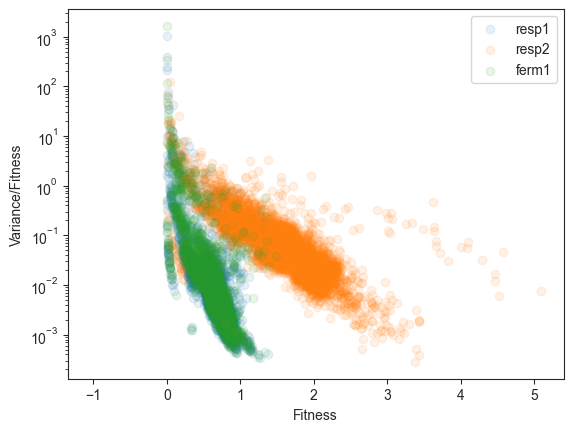

In [33]:
plt.scatter(resp_1Day_mean[0],resp_1Day_mean[1]**2/resp_1Day_mean[0],alpha=0.1,label='resp1')
plt.scatter(resp_2Day_mean[0],resp_2Day_mean[1]**2/resp_2Day_mean[0],alpha=0.1,label='resp2')
plt.scatter(ferm_1Day_mean[0],ferm_1Day_mean[1]**2/ferm_1Day_mean[0],alpha=0.1,label='ferm1')
plt.legend()
plt.yscale('log')
plt.xlabel('Fitness')
plt.ylabel('Variance/Fitness')

In [34]:
resp_2Day_mean

(array([2.7909072 , 3.38581999, 3.18227517, ..., 0.8116848 , 1.77997666,
        0.61140566]),
 array([0.0726903 , 0.0309616 , 0.06658936, ..., 0.47499085, 0.28923399,
        1.31235467]))

In [35]:
ferm_1Day_mean

(array([0.786138  , 0.93746599, 0.84849575, ..., 0.49121472, 0.73739942,
        0.68032192]),
 array([0.03133744, 0.02014222, 0.03187051, ..., 0.10853754, 0.05210276,
        0.51895807]))

,barcode,all_mutations,source_publication,Fit1D-2%-T0,Fit5D-2%-T0
36,CCGCCAATCCCGAACCCCGTTTCGCC_CCTAAAACATCCAAAGTTT...,NaN,This_study,977,626
70,CCGCCAATCCCGAACCCCGTTTCGCC_ACCGAAAAGCGCAATAGCA...,NaN,This_study,497,215
127,CCGCCAATCCCGAACCCCGTTTCGCC_ATTACAATCAGTAATATCA...,NaN,This_study,395,145
128,CCGCCAATCCCGAACCCCGTTTCGCC_TCTACAATAAGAAAAATAT...,NaN,This_study,465,200
136,CCGCCAATCCCGAACCCCGTTTCGCC_TGTAAAAGTTAGAATTTGC...,NaN,This_study,413,197
...,...,...,...,...,...
4926,AGAACAAAAACTAAACTCATTCATGG_AGTTAAATTGGAAAGGGTA...,NaN,This_study,3,1
4930,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTATAACTAAT...,NaN,This_study,6,1
4934,TTAAAAATACAAAAAAAGATTTAAGG_GCTAGAAAGACAAATGCCC...,NaN,This_study,1,3
4939,TTAAAAATACAAAAAAAGATTTAAGG_TTGTGAAAGACTAAGCACT...,NaN,This_study,0,2


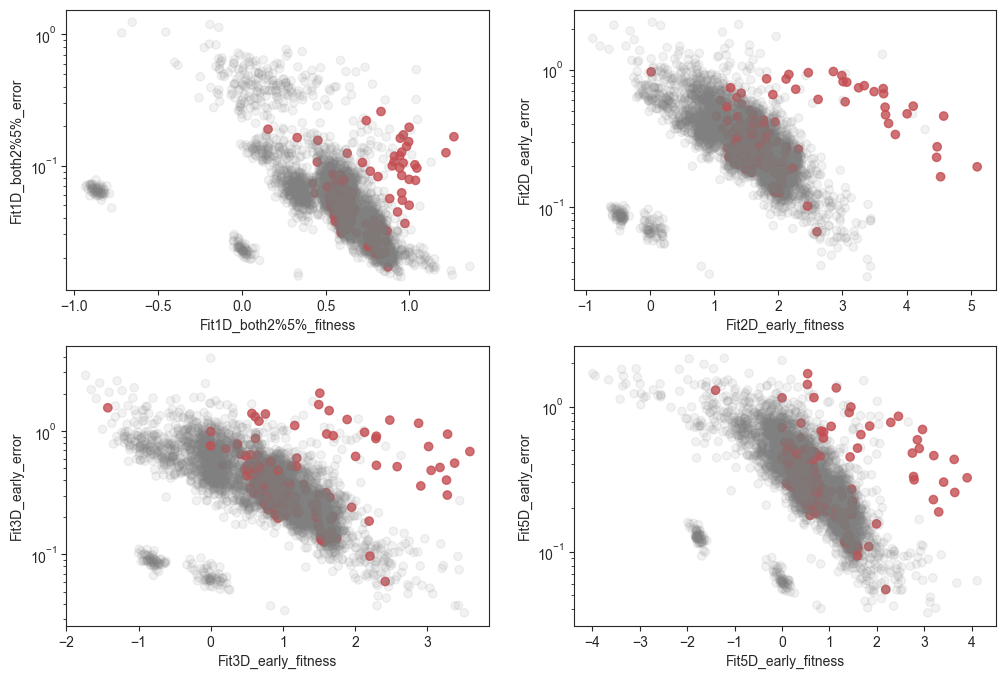

In [36]:
### Are barcodes where evolution condition is unknown too noisy?

plotting_conditions = ['Fit1D_both2%5%','Fit2D_early','Fit3D_early','Fit5D_early']
plt.figure(figsize=(12,8))
for c,condition in enumerate(plotting_conditions):
    plt.subplot(2,2,c+1)
    color_list = [matplotlib.colors.to_rgba('gray',0.1) if evo_cond != 'unknown' else matplotlib.colors.to_rgba('r',0.8)
                  for evo_cond in merged_fitness['evolution_condition'].values]
    
    plt.scatter(merged_fitness[f'{condition}_fitness'],merged_fitness[f'{condition}_error'],c=color_list)
#     plt.scatter(merged_fitness[f'{condition}_fitness'],np.abs(1.96*np.sqrt(merged_fitness[f'{condition}_error'])),c=color_list)
    plt.xlabel(f'{condition}_fitness')
    plt.ylabel(f'{condition}_error')
    
    plt.yscale('log')
    
merged_fitness[merged_fitness['evolution_condition']=='unknown'][['barcode','all_mutations','source_publication','Fit1D-2%-T0','Fit5D-2%-T0']]

In [37]:
merged_fitness[merged_fitness['evolution_condition'].isin(['unknown'])].to_csv(f'{home_dir}/data/intermediate/mutants_excluded_unknown_condition.csv')

In [38]:
#### Remove mutants with unknown evolution condition

merged_fitness = merged_fitness[~merged_fitness['evolution_condition'].isin(['unknown'])]

In [39]:
### Remove false barcodes that are sequencing errors from true barcode

seq_errors = {'TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA':[
    'TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTTATCA',
    'TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATAAATGGTATTCATCA']}

to_remove = tools.flatten(seq_errors.values())
              


In [40]:
merged_fitness = merged_fitness[~merged_fitness['barcode'].isin(to_remove)]

/Users/grantkinsler/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


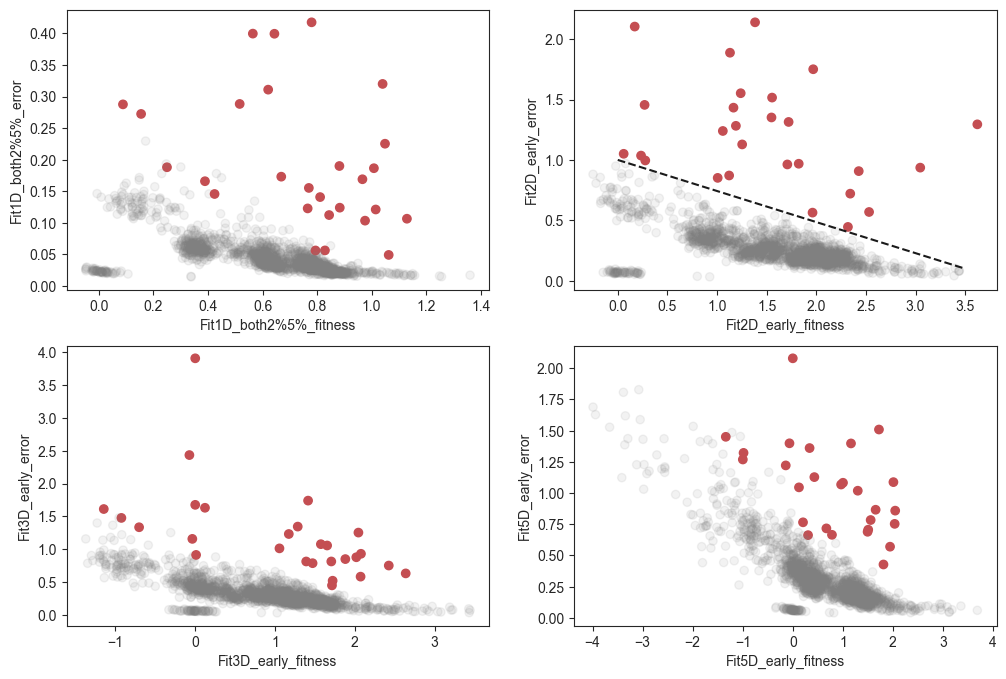

In [41]:
## Which other measurements are too noisy to be included?

this_study = merged_fitness[merged_fitness['source_publication'].isin(['Venkataram2015','Aggeli2021','This_study'])]

slope = (0.1-1.0)/3.5
noisy_mutants = [barcode  for barcode,f,e in zip(this_study['barcode'].values,
                                         this_study['Fit2D_early_fitness'].values,
                                         this_study['Fit2D_early_error'].values) if e>f*slope+1.0]
### Are barcodes where evolution condition is unknown too noisy?

plotting_conditions = ['Fit1D_both2%5%','Fit2D_early','Fit3D_early','Fit5D_early']
plt.figure(figsize=(12,8))
for c,condition in enumerate(plotting_conditions):
    plt.subplot(2,2,c+1)
    color_list = [matplotlib.colors.to_rgba('gray',0.1) if evo_cond != 'unknown' else matplotlib.colors.to_rgba('r',0.8)
                  for evo_cond in this_study['evolution_condition'].values]
    
    if condition == 'Fit2D_early':
        plt.plot([0.0,3.5],[1.0,0.1],'k--')
        
    slope = (0.1-1.0)/3.5
    color_list = [matplotlib.colors.to_rgba('gray',0.1) if e<f*slope+1.0 else 'r'
                  for f,e in zip(this_study['Fit2D_early_fitness'].values,this_study['Fit2D_early_error'].values)]


#     if condition == 'Fit1D_both2%5%':
#         plt.plot([0.0,1.2],[0.4,0.05],'k--')
        
#     slope = (0.02-0.7)/1.4
#     color_list = [matplotlib.colors.to_rgba('gray',0.1) if e<f*slope+0.7 else 'r'
#                   for f,e in zip(this_study['Fit1D_both2%5%_fitness'].values,this_study['Fit1D_both2%5%_error'].values)]
    
    plt.scatter(this_study[f'{condition}_fitness'],this_study[f'{condition}_error'],c=color_list)
#     plt.scatter(merged_fitness[f'{condition}_fitness'],np.abs(1.96*np.sqrt(merged_fitness[f'{condition}_error'])),c=color_list)
    plt.xlabel(f'{condition}_fitness')
    plt.ylabel(f'{condition}_error')
    
    
#    plt.yscale('log')
    
# merged_fitness[merged_fitness['evolution_condition']=='unknown'][['barcode','all_mutations','source_publication','Fit1D-2%-T0','Fit5D-2%-T0']]

In [42]:
merged_fitness[merged_fitness['barcode'].isin(noisy_mutants)][['barcode','source_publication','ancestor','gene']]

,barcode,source_publication,ancestor,gene
1182,CGCTAAAGACATAATGTGGTTTGTTG_ATGGTAACATGTAATCTAG...,Venkataram2015,WT,NotSequenced
1661,GTATTAAAATTAAAAATAATTGCACA_TTCTAAATATGGAATGGGG...,This_study,GPB2,NaN
1694,CGCTAAAGACATAATGTGGTTTGTTG_TAGACAAGTCTCAAGGTTG...,Venkataram2015,WT,NotSequenced
2550,CATTGAATCACAAAATAGGTTAGATG_CATGAAAAAATCAACTTTG...,This_study,IRA1_MIS,NaN
2997,CGCTAAAGACATAATGTGGTTTGTTG_CGCCTAAAATTTAATGCTT...,Venkataram2015,WT,NotSequenced
3414,CGCTAAAGACATAATGTGGTTTGTTG_AGTATAACACGAAAATAGC...,Venkataram2015,WT,NotSequenced
3424,CGCTAAAGACATAATGTGGTTTGTTG_TATCTAAAAATTAATCGAC...,Venkataram2015,WT,NotSequenced
3595,CGCTAAAGACATAATGTGGTTTGTTG_TGCTAAATCATAAAAATGC...,Venkataram2015,WT,NotSequenced
4041,CGCTAAAGACATAATGTGGTTTGTTG_GGTCGAAATCTTAATTGGT...,Venkataram2015,WT,NotSequenced
4288,CGCTAAAGACATAATGTGGTTTGTTG_AGAATAAGCAGGAAGTATT...,Venkataram2015,WT,other


In [43]:
merged_fitness = merged_fitness[~merged_fitness['barcode'].isin(noisy_mutants)]

In [44]:
def z_score_dist(fitness,error,centroid):
    
#     centroid_arr = 
    
    z_score = (fitness-centroid)/np.std(error)
    
    return z_score
    
def cutoff_z_score(fitness,error,centroid,cutoff=2):
    
    z_scores = z_score_dist(fitness,error,centroid)
    
    return [True if np.all(np.abs(z)<cutoff) else False for z in z_scores]
    

In [45]:
# class classification_set()

def classify_mutants(prior_set,data,distance_metric='mahalanobis',cutoff=3,counter=0,counter_cutoff=10):
    
    set_centroid = np.nanmean(data[prior_set,:],axis=0)
    set_covariance = np.cov(data[prior_set,:].swapaxes(0,1))
    # dists = distance.cdist(this_anc[calling_conditions],[pure_diploid_centroid])
    if distance_metric == 'mahalanobis':
        dists = distance.cdist(this_anc[calling_conditions].values,[set_centroid],
                           VI=np.linalg.inv(set_covariance),metric='mahalanobis') 
    
    new_set = [True if d<cutoff else False for d in dists]
    
    if prior_set == new_set:
        print('Converged!',counter,sum(new_set))
        
        return new_set, set_centroid, set_covariance, counter
    
    elif counter > counter_cutoff:
        print('Too many iterations!',counter,sum(new_set))
        
        set_centroid = np.nanmean(data[new_set,:],axis=0)
        set_covariance = np.cov(data[new_set,:].swapaxes(0,1))
        
        return new_set, set_centroid, set_covariance, counter
    
    else:
        print('Still going!',counter,sum(new_set))
        return classify_mutants(new_set,data,counter=counter+1,cutoff=cutoff,counter_cutoff=counter_cutoff)
        
    

In [46]:
import scipy

WT
Diploid, box: 233
Still going! 0 228
Still going! 1 224
Still going! 2 222
Converged! 3 222
Neutral, box: 59
Still going! 0 58
Converged! 1 58
Calling as pure diploid E2-88-9-C5 Diploid-NotSequenced; NotSequenced
called pure diploid, found causal mutation E2-88-1-D10 other Haploid
called pure diploid, found causal mutation E2-88-2-C10 SCH9 Haploid
Calling as pure diploid E2-88-9-E1 NotSequenced
Calling as pure diploid 131025-1-E11 Diploid-NotSequenced; NotSequenced
Calling as pure diploid 130822-1-A7 NotSequenced
Calling as pure diploid 131101-3-F9 Diploid-NotSequenced; NotSequenced
Calling as pure diploid E2-88-10-F1 Diploid-NotSequenced; NotSequenced
called neutral haploid, found causal mutation 131025-1-E6 other Haploid
Calling as pure diploid 131101-1-E10 NotSequenced
called neutral haploid, found causal mutation 131010-2-F11 other Haploid
484 484
CYR1
Diploid, box: 187
Still going! 0 281
Still going! 1 300
Converged! 2 300
Neutral, box: 100
Still going! 0 233
Still going! 1 321

/Users/grantkinsler/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/Users/grantkinsler/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


GPB2
Diploid, box: 239
Still going! 0 283
Still going! 1 305
Still going! 2 312
Still going! 3 315
Converged! 4 315
Neutral, box: 161
Still going! 0 652
Still going! 1 856
Still going! 2 935
Still going! 3 963
Still going! 4 971
Still going! 5 974
Still going! 6 975
Still going! 7 976
Still going! 8 977
Converged! 9 977
Calling as pure diploid gpb2_evo1_plate5_D10 nan
Calling as neutral haploid gpb2_evo1_plate4_H10 nan
Calling as pure diploid gpb2_evo2_plate8_C11 nan
Calling as neutral haploid gpb2_evo2_plate8_B2 nan
Calling as neutral haploid gpb2_evo2_plate3_H11 nan
Calling as neutral haploid gpb2_evo1_plate10_A11 nan
Calling as neutral haploid gpb2_evo2_plate7_G6 nan
Calling as pure diploid EVO1D_TCG_rearray_Plate3-D3 nan
Calling as neutral haploid EVO1D_TCG_rearray_Plate3-F5 nan
Calling as pure diploid gpb2_evo1_plate10_A2 nan
Calling as neutral haploid gpb2_evo2_plate8_D12 nan
Calling as pure diploid gpb2_evo1_plate10_B11 nan
Calling as neutral haploid gpb2_evo1_plate9_C4 nan
Call

/Users/grantkinsler/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/Users/grantkinsler/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


TOR1
Diploid, box: 139
Still going! 0 294
Still going! 1 374
Still going! 2 439
Still going! 3 457
Still going! 4 461
Converged! 5 461
Neutral, box: 29
Still going! 0 87
Still going! 1 185
Still going! 2 284
Still going! 3 328
Still going! 4 341
Still going! 5 347
Still going! 6 352
Still going! 7 354
Converged! 8 354
Calling as pure diploid EVO1D_TCG_rearray_Plate2-E11 nan
Calling as pure diploid tor1_evo1_plate1_C12 nan
Calling as pure diploid tor1_evo1_plate5_D9 nan
Calling as pure diploid tor1_evo1_plate9_B6 nan
Calling as pure diploid tor1_evo1_plate8_A9 nan
Calling as pure diploid tor1_evo1_plate7_B5 nan
Calling as pure diploid tor1_evo1_plate3_H11 nan
Calling as pure diploid tor1_evo1_plate1_H6 nan
Calling as neutral haploid nan nan
Calling as neutral haploid tor1_evo1_plate6_E1 nan
Calling as pure diploid EVO1D_TCG_rearray_Plate6-F8 nan
Calling as neutral haploid tor1_evo1_plate3_E9 nan
Calling as neutral haploid nan nan
called pure diploid, found causal mutation tor1_evo1_plat

/Users/grantkinsler/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/Users/grantkinsler/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


IRA1_MIS
Diploid, box: 111
Still going! 0 104
Still going! 1 101
Still going! 2 100
Converged! 3 100
Neutral, box: 87
Still going! 0 115
Still going! 1 120
Converged! 2 120
Calling as pure diploid EVO2D_IRA1_MIS_rearray_Plate2-A4 ['IRA1:missense_variant:HOM', 'GIS2:upstream_gene_variant:HOM', 'MDH2:upstream_gene_variant:HOM']
Calling as neutral haploid EVO1D_IRAs_rearray_Plate3-C8 nan
called pure diploid, found causal mutation EVO1D_IRAs_rearray_Plate2-B11 TFA1 ?
Calling as neutral haploid EVO1D_IRAs_rearray_Plate3-B8 nan
Calling as neutral haploid EVO1D_IRAs_rearray_Plate2-B4 ['IRA1:missense_variant:HOM']
Calling as neutral haploid EVO1D_IRAs_rearray_Plate1-A10 nan
called pure diploid, found causal mutation EVO2D_IRA1_MIS_rearray_Plate2-E1 BMH2 diploid
365 365
IRA1_NON
Diploid, box: 0
Converged! 0 0
Neutral, box: 0
Converged! 0 0
241 241


/Users/grantkinsler/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/Users/grantkinsler/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_53280/1947742696.py:5: RuntimeWarning: Mean of empty slice
  set_centroid = np.nanmean(data[prior_set,:],axis=0)
/Users/grantkinsler/opt/miniconda3/lib/python3.9/site-

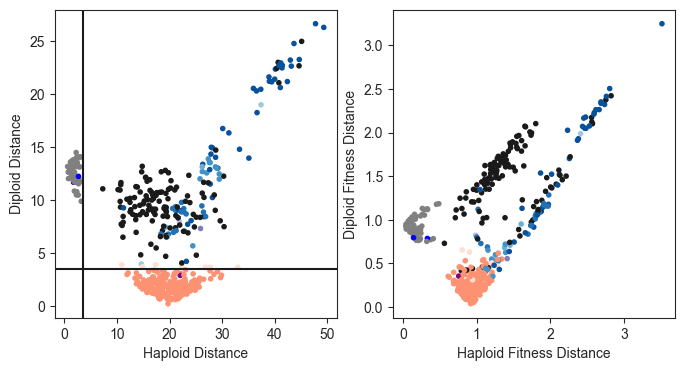

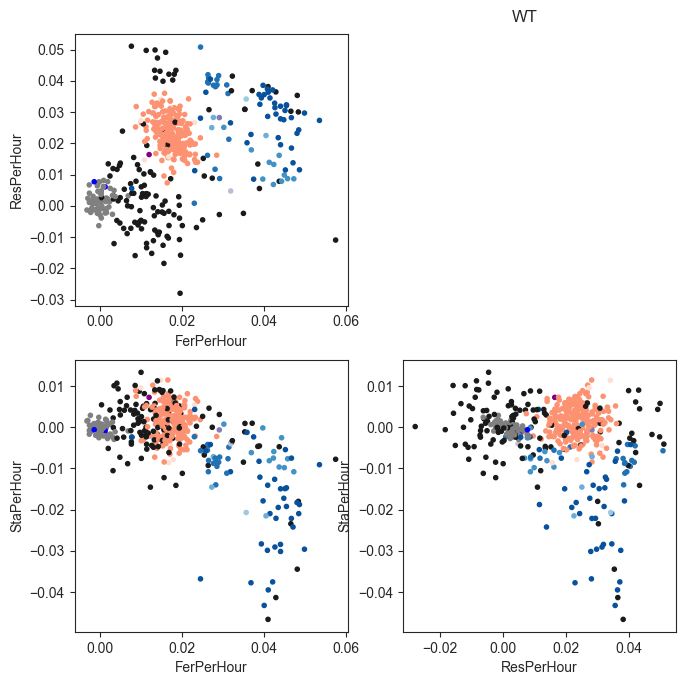

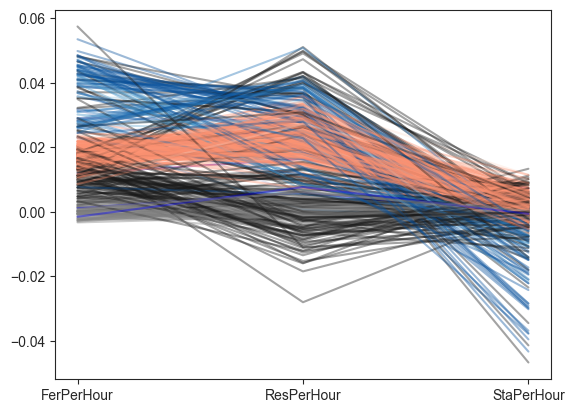

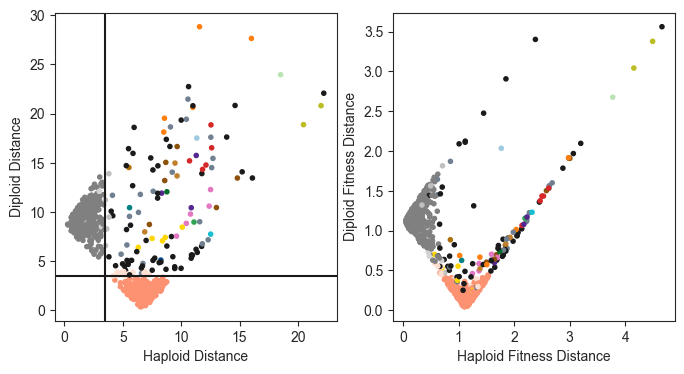

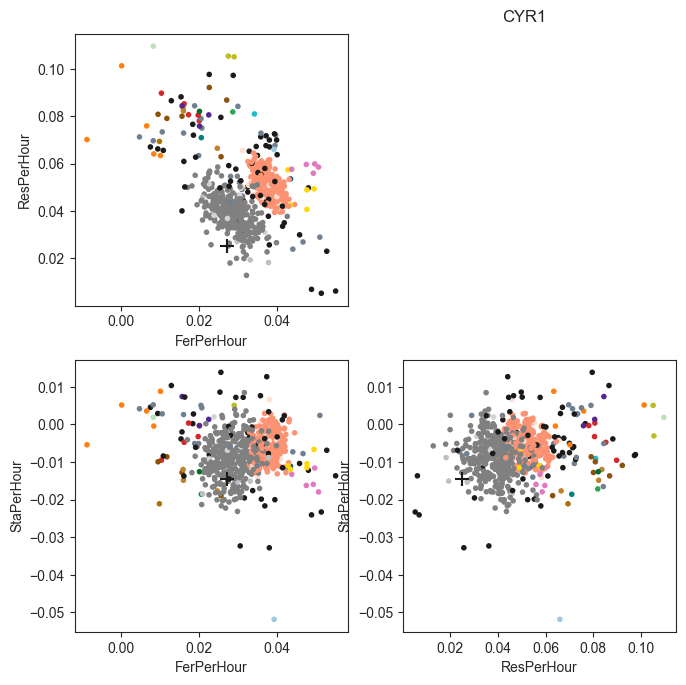

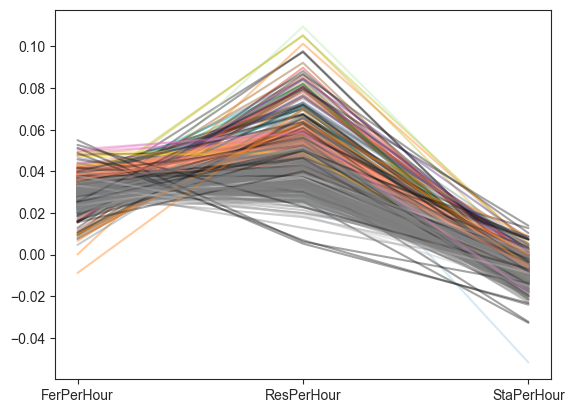

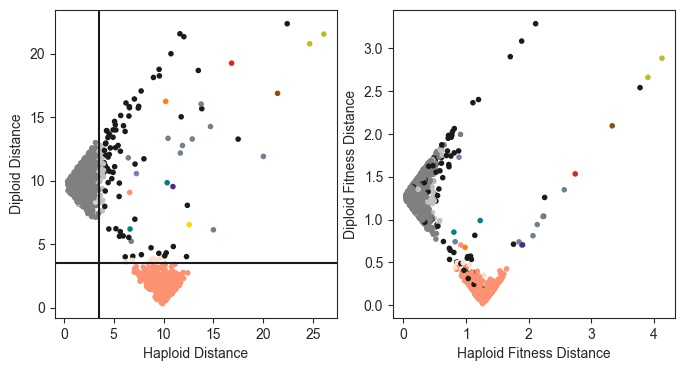

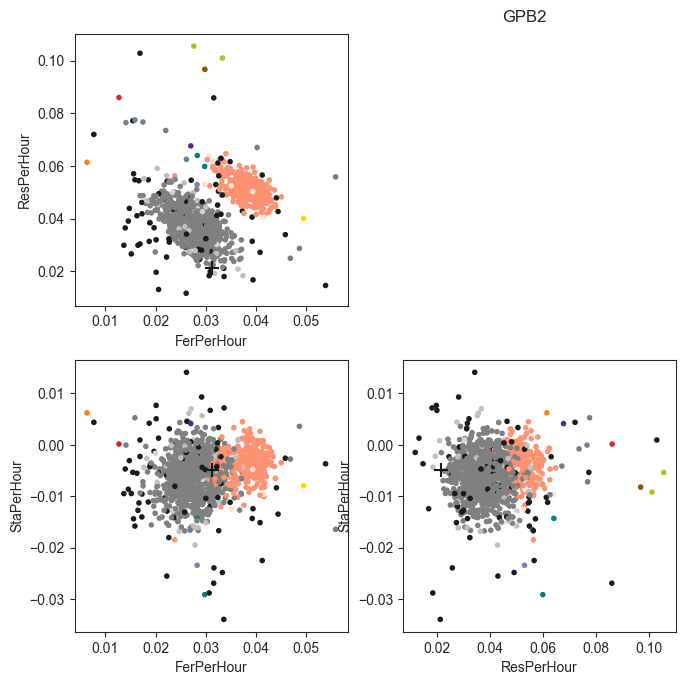

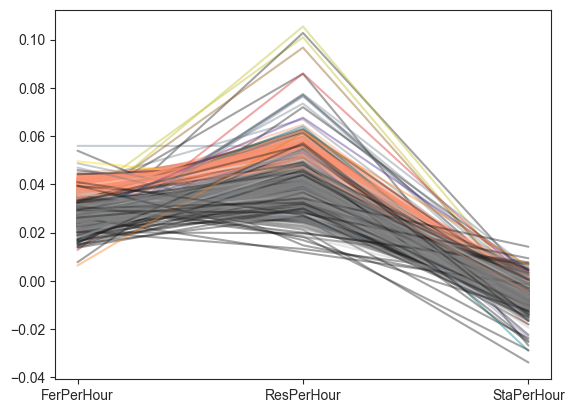

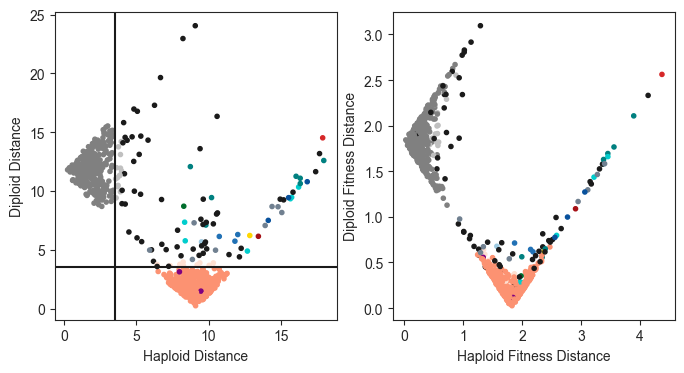

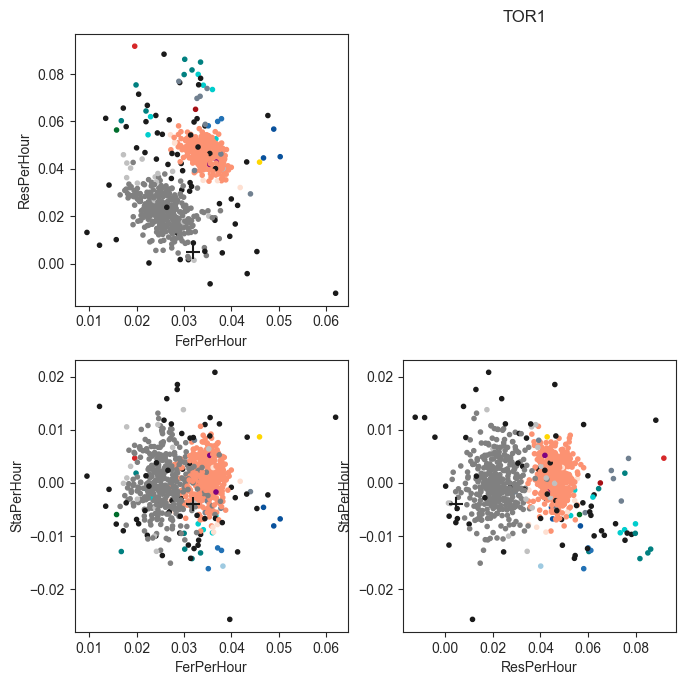

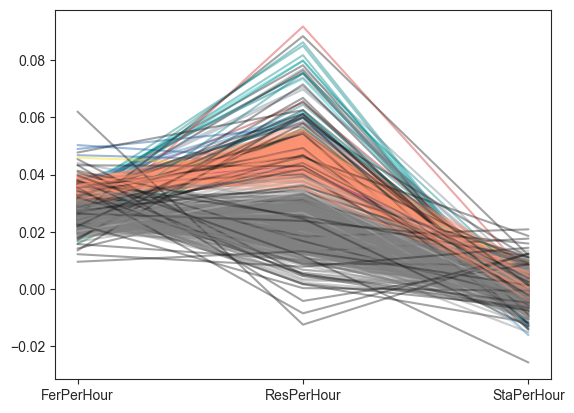

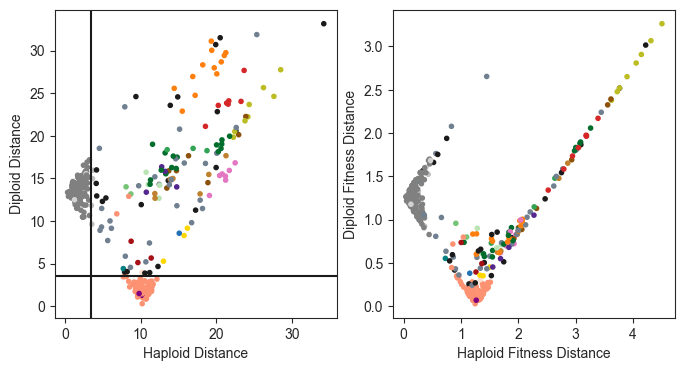

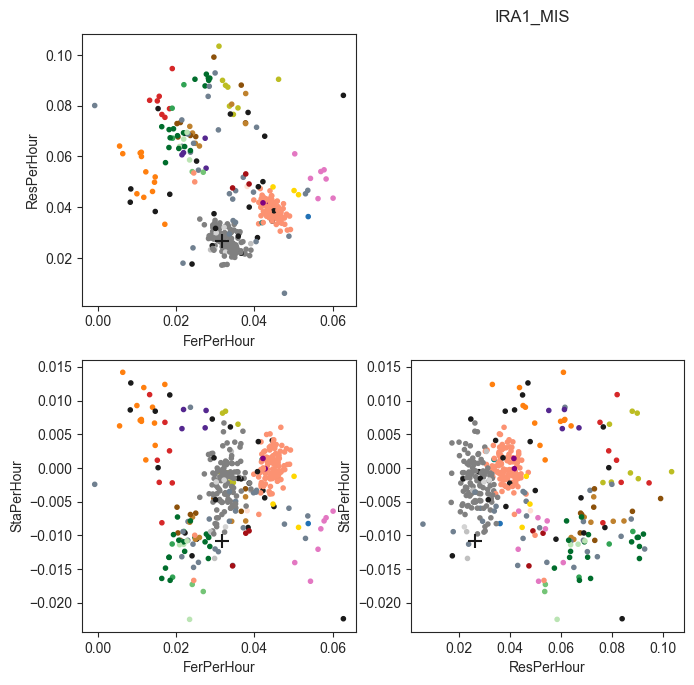

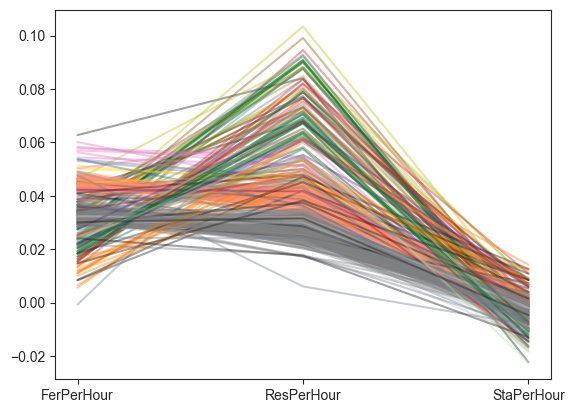

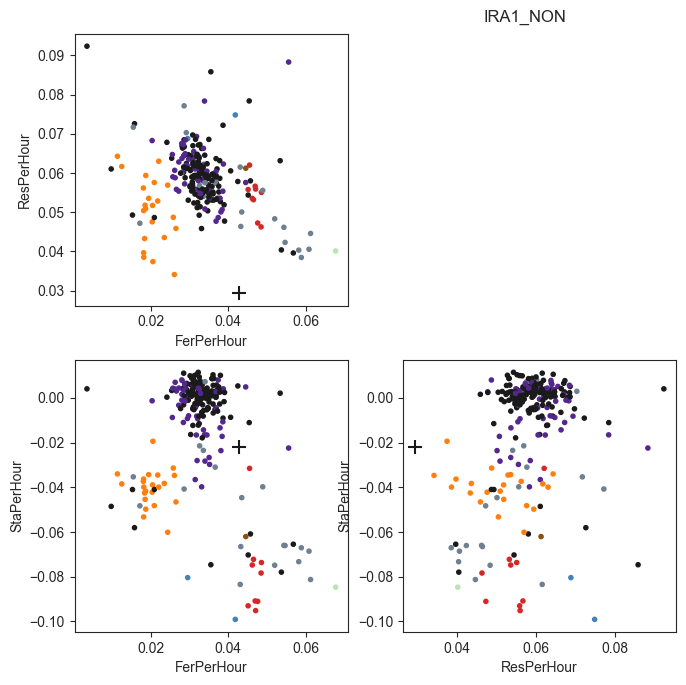

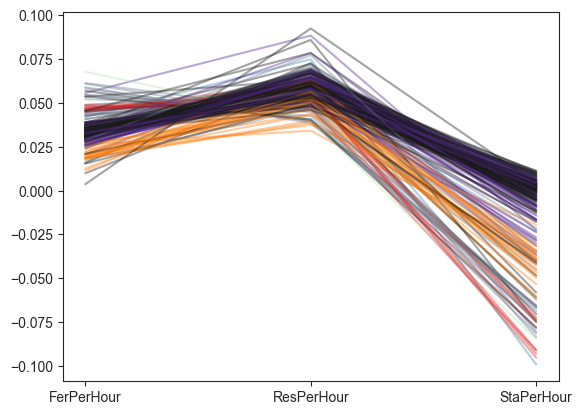

In [47]:
# Calling pure diploids and neutral haploids. According to 1 Day and 2 Day fitness (most accurate atm)
ancestor_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
ancestor_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
# ancestor_list = ['CYR1']
# calling_conditions = ['Fit1D_both2%5%_fitness','Fit2D_early_fitness','StaPerHour']

calling_conditions = ['Fit1D_both2%5%_fitness','Fit2D_early_fitness','Fit5D_early_fitness','Fit3D_early_fitness']
# calling_conditions = ['Fit1D_both2%5%_fitness','Fit2D_early_fitness','Fit3D_early_fitness','Fit5D_early_fitness']
calling_errors = [col.replace('fitness','error') for col in calling_conditions]
# plotting_conditions = ['Fit1D_both2%5%_fitness','Fit2D_early_fitness','Fit3D_early_fitness','Fit5D_early_fitness']
plotting_conditions = ['FerPerHour','ResPerHour','StaPerHour']


plotting_errors = [col.replace('fitness','error') for col in plotting_conditions]


### prior for what's a haploid/diploid by eye
haploid_cutoffs = {
            'WT':[(-0.25,0.25),(-0.25,0.25),(-0.5,0.5),(-0.5,0.5)],
            'CYR1':[(0.5,0.7),(1.0,2.0),(0.0,1.0),(1.0,2.0)],
           'GPB2':[(0.5,0.7),(1.0,2.0),(-0.1,1.1),(1.0,2.0)],
           'TOR1':[(0.4,0.6),(0.3,1.5),(-0.5,0.5),(0.3,1.5)],
           'IRA1_MIS':[(0.5,0.7),(0.75,1.5),(-0.1,0.5),(0.25,0.75)],
           'IRA1_NON':[[0.0,0.0],[0.0,0.0],(0.0,0.0),[0.0,0.0]]}

diploid_cutoffs = {
            'WT':[(0.25,0.5),(0.5,1.25),(-0.5,0.5),(-0.5,0.5)],
            'CYR1':[(0.75,0.9),(1.5,2.5),(1.0,2.0),(1.5,2.5)],
           'GPB2':[[0.72,0.9],[1.5,2.4],(0.5,1.8),[1.5,2.4]],
           'TOR1':[[0.65,0.85],[1.25,2.25],(0.5,1.6),[1.25,2.25]],
#            'IRA1_MIS':[[0.75,1.2],[1.4,2.2],(0.8,1.5)],
            'IRA1_MIS':[[0.75,0.95],[1.4,2.2],(0.8,1.5),[0.75,1.5]],
           'IRA1_NON':[[0.0,0.0],[0.0,0.0],(0.0,0.0),[0.0,0.0]]}

to_sequence = {}
missing_targets = {}
already_sequenced = {}
pure_diploid_dict = {}
neutral_haploid_dict = {}

for a,anc in enumerate(ancestor_list):
    print(anc)
    this_anc = merged_fitness[(merged_fitness['ancestor']==anc) & (merged_fitness['source_publication']!='Li2019')]
#     for evo_cond in np.unique(this_anc['evolution_condition'].values):

#     background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]
    
    dist_cutoff = 3.5

    percentile_cutoff = 10

    pure_diploids_prior = [True if np.all([x > diploid_cutoffs[anc][0][0],
                               x < diploid_cutoffs[anc][0][1],
                               y > diploid_cutoffs[anc][1][0],
                               y < diploid_cutoffs[anc][1][1],
                               z > diploid_cutoffs[anc][2][0],
                               z < diploid_cutoffs[anc][2][1],
                               q > diploid_cutoffs[anc][3][0],
                               q < diploid_cutoffs[anc][3][1],
                                    ]) else False
                     for x,y,z,q in this_anc[calling_conditions].values]
    print('Diploid, box:',sum(pure_diploids_prior))
    
    pure_diploids, pure_diploid_centroid, pure_diploid_cov, counter = classify_mutants(pure_diploids_prior,this_anc[calling_conditions].values,
                                                                                      cutoff=dist_cutoff)
    
    pure_diploid_dict[anc] = list(this_anc['barcode'].values[pure_diploids])
    
    # first define by the manual boxes
    neutral_haploids_prior = [True if np.all([x > haploid_cutoffs[anc][0][0],
                               x < haploid_cutoffs[anc][0][1],
                               y > haploid_cutoffs[anc][1][0],
                               y < haploid_cutoffs[anc][1][1],
                               z > haploid_cutoffs[anc][2][0],
                               z < haploid_cutoffs[anc][2][1],
                               q > haploid_cutoffs[anc][3][0],
                               q < haploid_cutoffs[anc][3][1],
                                       ]) else False
                     for x,y,z,q in this_anc[calling_conditions].values]
    print('Neutral, box:',sum(neutral_haploids_prior))

    neutral_haploids, neutral_haploid_centroid, neutral_haploid_cov, counter = classify_mutants(neutral_haploids_prior,this_anc[calling_conditions].values,
                                                                                               cutoff=dist_cutoff)


    neutral_haploid_dict[anc] = list(this_anc['barcode'].values[neutral_haploids])
#     neutral_haploid_centroid = np.nanmean(this_anc[calling_conditions].values[neutral_haploids,:],axis=0)
#     neutral_haploid_cov = np.cov(this_anc[calling_conditions].values[neutral_haploids,:].swapaxes(0,1))
#     dists = distance.cdist(this_anc[calling_conditions],[neutral_haploid_centroid])
    ploidys = this_anc['ploidy_new'].values
    bcs = this_anc['barcode'].values
    colors = []
    
    haploid_fitness_dists = distance.cdist(this_anc[calling_conditions].values,[neutral_haploid_centroid]) 
    diploid_fitness_dists = distance.cdist(this_anc[calling_conditions].values,[pure_diploid_centroid])
    
    diploid_dists = distance.cdist(this_anc[calling_conditions].values,[pure_diploid_centroid],
                           VI=np.linalg.inv(pure_diploid_cov),metric='mahalanobis') 
    haploid_dists = distance.cdist(this_anc[calling_conditions].values,[neutral_haploid_centroid],
                           VI=np.linalg.inv(neutral_haploid_cov),metric='mahalanobis') 
    
#     to_sequence[anc] = []
#     missing_targets[anc] = [] 
#     already_sequenced[anc] = []
    for entry in range(len(ploidys)):
        newCloneID = this_anc['cloneID_new'].values[entry]
        gene_from_previous_data = this_anc['additional_muts'].values[entry]
        gene = this_anc['gene'].values[entry]
        this_barcode = this_anc['barcode'].values[entry]
#         old_class = this_anc['class'].values[entry]
        
        if pure_diploids[entry] == True:
            if gene not in ['',np.nan,'Diploid','NotSequenced','Diploid-NotSequenced']:
                colors.append('purple') # it was called pure diploid, but we found a putative causal mutation!
                print('called pure diploid, found causal mutation',newCloneID,gene,ploidys[entry])
            elif ploidys[entry] in ['diploid','Diploid']:
                colors.append('#fc9272') # light red, it's called pure diploid and is diploid 
            else:
#                 colors.append('#fee0d2') # very light red, it's called pure diploid but we didn't see ploidy on benomyl
                colors.append('#fc9272') # very light red, it's called pure diploid but we didn't see ploidy on benomyl


        elif neutral_haploids[entry] == True:
            if gene not in ['',np.nan,'NotSequenced']:
                colors.append('blue') # it was called pure haploid, but we found a putative causal mutation!
                print('called neutral haploid, found causal mutation',newCloneID,gene,ploidys[entry])
            elif ploidys[entry] in ['diploid','Diploid']:
                colors.append('lightgray') # neutral haploid but ploidy called diploid
            else:
                colors.append('gray') # neutral haploid and ploidy is 
        else:
            if gene in tools.mutation_color_map.keys():
                colors.append(tools.mutation_color_map[gene])
            elif ploidys[entry] in ['diploid','Diploid']:
                if diploid_dists[entry] < 4:
                    ### if there's a mutant that's kind of close, is diploid, has no called mutations, classify as diploid
                    print('Calling as pure diploid',newCloneID,this_anc['all_mutations'].values[entry])
                    colors.append('#fee0d2') 
                    pure_diploid_dict[anc].append(this_barcode)
                
                elif gene in ['']:
                    colors.append('slategray')
                else:
                    colors.append('k')
            
            elif haploid_dists[entry] < 4:
                print('Calling as neutral haploid',newCloneID,this_anc['all_mutations'].values[entry])
                colors.append('silver') 
                neutral_haploid_dict[anc].append(this_barcode)
            else:
                if gene in ['']:
                    colors.append('slategray')
                else:
                    colors.append('k')
                    
    
    if anc != 'IRA1_NON':
        
        
        diploid_dists = distance.cdist(this_anc[calling_conditions].values,[pure_diploid_centroid],
                           VI=np.linalg.inv(pure_diploid_cov),metric='mahalanobis') 
        haploid_dists = distance.cdist(this_anc[calling_conditions].values,[neutral_haploid_centroid],
                           VI=np.linalg.inv(neutral_haploid_cov),metric='mahalanobis') 
        
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.scatter(haploid_dists,
                        diploid_dists,
                        color=colors,marker='.')
        plt.xlabel('Haploid Distance')
        plt.ylabel('Diploid Distance')
        plt.axvline(dist_cutoff,color='k')
        plt.axhline(dist_cutoff,color='k')
        
        plt.subplot(1,2,2)
        haploid_fitness_dists = distance.cdist(this_anc[calling_conditions].values,[neutral_haploid_centroid]) 
        diploid_fitness_dists = distance.cdist(this_anc[calling_conditions].values,[pure_diploid_centroid])
        plt.scatter(haploid_fitness_dists,
                        diploid_fitness_dists,
                        color=colors,marker='.')

        plt.xlabel('Haploid Fitness Distance')
        plt.ylabel('Diploid Fitness Distance')
            
    print(len(colors),len(ploidys))
    
    plt.figure(figsize=(12,12))
    plt.suptitle(anc,y=0.9)    
    
    counter = 0
    for c1,c2 in combinations(plotting_conditions,2):
        c1_loc = np.where(np.isin(plotting_conditions,c1))[0][0]
        c2_loc = np.where(np.isin(plotting_conditions,c2))[0][0]
#         print(c1_loc+(c2_loc)*3+1)
        plt.subplot(3,3,c1_loc+(c2_loc-1)*3+1)
        plt.scatter(this_anc[c1],this_anc[c2],marker='.',color=colors)
        plt.xlabel(c1)
        plt.ylabel(c2)
        counter+=1
        if anc != 'WT':
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]
            plt.scatter(background_mutant[c1].values,background_mutant[c2].values,marker='+',color='k',s=100)

#     plt.savefig(f'plots/WGS_targets_{anc}.pdf',bbox_inches='tight')
    
    plt.figure()
    for entry in range(len(this_anc.index)):
        plt.plot(this_anc[plotting_conditions].values[entry,:],color=colors[entry],alpha=0.4)
    plt.xticks(range(len(plotting_conditions)),plotting_conditions)
                

In [48]:
# merged_fitness[((merged_fitness['ancestor']=='IRA1_MIS') & 
#                (merged_fitness['FerPerHour']> 0.03) & 
#                (merged_fitness['FerPerHour']< 0.05 ) & 
#                (merged_fitness['ResPerHour']>0.04 ) & 
#                (merged_fitness['ResPerHour']<0.06 ) &
#                (~p.isnull(merged_fitness['gene']))
#                )][['barcode','gene','all_mutations','ploidy_new']].values

In [49]:
merged_fitness[merged_fitness['barcode'].isin(neutral_haploid_dict['IRA1_MIS'])][['barcode','gene','ploidy_new']].values

array([['CATAAAAAGACTAATCTTATTAATGC_TAGACAATCTACAATTACTTTCACGT', nan,
        '?'],
       ['CATAAAAAGACTAATCTTATTAATGC_CAAGGAATCGTCAAGCGTGTTCGTGG', nan,
        '?'],
       ['CATAAAAAGACTAATCTTATTAATGC_GCGGCAACAATAAATACTGTTCACGT', nan,
        '?'],
       ['CATAAAAAGACTAATCTTATTAATGC_GGGCTAAGGGCCAACGGGCTTGCGGC', nan,
        '?'],
       ['CATAAAAAGACTAATCTTATTAATGC_TCCCCAAAAGCAAACGGGATTGAGGT', nan,
        '?'],
       ['CATAAAAAGACTAATCTTATTAATGC_ACGCGAAGGCAAAAGTTAATTCCCTG', nan,
        '?'],
       ['CATAAAAAGACTAATCTTATTAATGC_AGTCCAACTTACAATTAACTTAAGTC', nan,
        '?'],
       ['CATAAAAAGACTAATCTTATTAATGC_ATACCAAAGGCCAAGACGGTTTCGGAG', nan,
        '?'],
       ['TGATCAATCTACAAAAATATTTAATG_GCGAGAAGGGTTAATGAACTTCAGCC', nan,
        'haploid'],
       ['CATAAAAAGACTAATCTTATTAATGC_GGTATAACACCTAATACACTTACAAT', nan,
        '?'],
       ['CATAAAAAGACTAATCTTATTAATGC_GGGCAAAGTTGAAAGGCCTTTGGGCC', nan,
        '?'],
       ['CATAAAAAGACTAATCTTATTAATGC_TTTGTAATGCGCAATCTGATTTCAAT', nan,

In [50]:
class_new_list = []
for anc,barcode,old_class,ploidy_new in zip(merged_fitness['ancestor'].values,
                                            merged_fitness['barcode'].values,
                                            merged_fitness['class'].values,
                                            merged_fitness['ploidy_new'].values):
    if anc in ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']:
        if barcode in neutral_haploid_dict[anc]:
            class_new_list.append('neutral_haploids')
        elif barcode in pure_diploid_dict[anc]:
            class_new_list.append('pure_diploids')
        else:
            if old_class == 'pure_diploids':
                class_new_list.append('pure_diploids')
            elif old_class == 'neutral_haploids':
                class_new_list.append('neutral_haploids')
            elif ploidy_new in (['diploid','Diploid']):
                class_new_list.append('high_fitness_diploids')
            else:
                class_new_list.append('adaptive_haploid')
        
    else:
        class_new_list.append(old_class)
merged_fitness['class_new'] = class_new_list

In [51]:
relative_list = ['FerPerHour','ResPerHour','StaPerHour',
                 'Fit1D_both2%5%_fitness','Fit2D_both2%5%_fitness','Fit2D_early_fitness','Fit3D_early_fitness','Fit5D_early_fitness']

neutral_vals = {}

for anc in ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']:
    neutral_vals[anc] = {}
    for performance in relative_list:
        
        if anc == 'WT':
#             this_anc = merged_fitness[(merged_fitness['source_publication'] != 'Li2019') & 
#                                      (merged_fitness['ancestor']=='WT')]
            
            neutral_vals[anc][performance] = 0
            
            
        elif anc == 'IRA1_NON':
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

            neutral_vals[anc][performance] = background_mutant[performance].values[0]           
            
        else:
            this_neutral_haploid = merged_fitness[(merged_fitness['ancestor']==anc) & 
                                                  (merged_fitness['class_new']=='neutral_haploids')]
            
            neutral_vals[anc][performance] = np.nanmean(this_neutral_haploid[performance].values)
            
            
to_be_added = {}            
            
for performance in relative_list:
    to_be_added[f'{performance}_relative'] = []
    to_be_added[f'{performance}_ancestor'] = []
    for barcode,anc,value in zip(merged_fitness['barcode'].values,
                                        merged_fitness['ancestor'].values,
                                       merged_fitness[f'{performance}'].values):
        
#         print(value)
    
        to_be_added[f'{performance}_relative'].append(value - neutral_vals[anc][performance])
        to_be_added[f'{performance}_ancestor'].append(neutral_vals[anc][performance])
        
for performance in relative_list:
    merged_fitness[f'{performance}_relative'] = to_be_added[f'{performance}_relative']
    merged_fitness[f'{performance}_ancestor'] = to_be_added[f'{performance}_ancestor']
    
    
    


In [52]:
## additionally, remove some mutants where all fitnesses are close to ancestor and no mutations have been identified 

# filters = ['FerPerHour','ResPerHour','StaPerHour']
# multiplier = 1

# noisy_neutrals = (np.all(merged_fitness[filters].values+multiplier*merged_fitness[[f+'_error' for f in filters]].values>merged_fitness[[f+'_ancestor' for f in filters]].values,axis=1)&
#             np.all(merged_fitness[filters].values-multiplier*merged_fitness[[f+'_error' for f in filters]].values<merged_fitness[[f+'_ancestor' for f in filters]].values,axis=1))
# noisy_neutral_ixs = np.where(noisy_neutrals)[0]

filters = ['Fit1D_both2%5%_fitness','Fit2D_early_fitness','Fit3D_early_fitness','Fit5D_early_fitness']

multiplier = 2

noisy_nonadaptives = (np.all(merged_fitness[filters].values-multiplier*merged_fitness[[f.replace('fitness','error') for f in filters]].values<merged_fitness[[f+'_ancestor' for f in filters]].values,axis=1))
noisy_nonadaptive_ixs = np.where(noisy_nonadaptives)[0]

# noisy_nonadaptives = (np.all(merged_fitness[filters].values+multiplier*merged_fitness[[f.replace('fitness','error') for f in filters]].values>merged_fitness[[f+'_ancestor' for f in filters]].values,axis=1)&
#             np.all(merged_fitness[filters].values-multiplier*merged_fitness[[f.replace('fitness','error') for f in filters]].values<merged_fitness[[f+'_ancestor' for f in filters]].values,axis=1))


# merged_fitness['class_new'] = [class_new if ((class_new in ['neutral_haploids','pure_diploids','high_fitness_diploids']) or (i not in noisy_neutral_ixs) or (not gene in [np.nan,'NotSequenced'])) else 'noisy_neutral' 
#                                for i,(class_new,gene) in enumerate(zip(merged_fitness['class_new'].values,merged_fitness['gene'].values))]

merged_fitness['class_new'] = [class_new if ((class_new in ['neutral_haploids','pure_diploids','high_fitness_diploids']) or (i not in noisy_nonadaptive_ixs) or (not gene in [np.nan,'NotSequenced'])) else 'noisy_neutral' 
                               for i,(class_new,gene) in enumerate(zip(merged_fitness['class_new'].values,merged_fitness['gene'].values))]

# print(merged_fitness[merged_fitness['class_new']=='noisy_neutral'][['barcode','ancestor','evolution_condition','gene']])                                           
print(len(merged_fitness[merged_fitness['class_new']=='noisy_neutral']))    

merged_fitness = merged_fitness[merged_fitness['class_new']!='noisy_neutral']

49


In [53]:
### manually add double mutants with extreme fitness/performances:

manual_doubles = {
    'ATCACAATAACTAAACTGATTCTTCA_CTCATAACATCAAAAAAAATTCAAAT':
        ['KSP1+TAN1','frameshift_variantstop_gained+missense_variant'],
    'CCGCCAATCCCGAACCCCGTTTCGCC_ATGTTAACAAGAAAGACCTTTCTAAG':
        ['ATE1+EEB1','missense_variant+stop_gained'],
    'TATCGAAACCCAAAGAGATTTAATCG_CGATCAAAGACTAACTTATTTTGTGG':
        ['IRA1+MKT1+SPB1','stop_gained+missense_variant+missense_variant'],
#     'CATTGAATCACAAAATAGGTTAGATG_CTCAAAAACAAAAATAAAATTGTTAC':
#         ['MKT1+SEC63','missense_variant+missense_variant'], # This is just MKT1 + Diploidy
}

genes = []
effects = []

for barcode,gene,effect in zip(merged_fitness['barcode'].values,
                               merged_fitness['gene'].values,
                               merged_fitness['effect'].values):
    if barcode in manual_doubles.keys():
        genes.append(manual_doubles[barcode][0])
        effects.append(manual_doubles[barcode][1])
    else:
        genes.append(gene)
        effects.append(effect)
        
merged_fitness['gene'] = genes
merged_fitness['effect'] = effects

In [54]:
## manually override PAB1 ploidy calls:

classes = []
ploidys = []

for barcode,gene,class_new,ploidy_new,resp in zip(merged_fitness['barcode'].values,
                                             merged_fitness['gene'].values,
                                             merged_fitness['class_new'].values,
                                             merged_fitness['ploidy_new'].values,
                                            merged_fitness['ResPerHour_relative'].values,
                                            ):
    
    if gene == 'PAB1':
        if resp > 0.06:
            classes.append('high_fitness_diploids')
            ploidys.append('diploid')
        else:
            classes.append('adaptive_haploid')
            ploidys.append('haploid')
        
    else:
        classes.append(class_new)
        ploidys.append(ploidy_new)
        
merged_fitness['class_new'] = classes
merged_fitness['ploidy_new'] = ploidys

In [55]:
merged_fitness.to_csv(f'{home_dir}/data/fitness_withMutations.csv')

In [56]:
merged_fitness[merged_fitness['gene']=='PAB1'][['gene','ploidy_new','class_new']]

,gene,ploidy_new,class_new
3,PAB1,haploid,adaptive_haploid
10,PAB1,diploid,high_fitness_diploids
46,PAB1,haploid,adaptive_haploid
64,PAB1,haploid,adaptive_haploid
75,PAB1,haploid,adaptive_haploid
153,PAB1,haploid,adaptive_haploid
292,PAB1,haploid,adaptive_haploid
780,PAB1,haploid,adaptive_haploid
878,PAB1,haploid,adaptive_haploid
1170,PAB1,diploid,high_fitness_diploids


In [57]:
np.unique([entry for entry in merged_fitness[(merged_fitness['ancestor']=='WT') & 
                                             (merged_fitness['source_publication']!='Li2019')
                                            ]['class'].values if not p.isnull(entry)],return_counts=True)

(array(['adaptive_haploids', 'high_fitness_diploids', 'neutral_haploids',
        'pure_diploids'], dtype='<U21'),
 array([ 76,  21, 127, 191]))

In [58]:
merged_fitness[(merged_fitness['ancestor']=='WT') & 
                                             (merged_fitness['source_publication']!='Li2019')]

,Fit1D-2%-R1_fitness,Fit1D-2%-R1_error,Fit1D-2%-R2_fitness,Fit1D-2%-R2_error,Fit1D-5%-R1_fitness,Fit1D-5%-R1_error,Fit1D-5%-R2_fitness,Fit1D-5%-R2_error,Fit2D-2%-R1_fitness,Fit2D-2%-R1_error,...,Fit1D_both2%5%_fitness_relative,Fit1D_both2%5%_fitness_ancestor,Fit2D_both2%5%_fitness_relative,Fit2D_both2%5%_fitness_ancestor,Fit2D_early_fitness_relative,Fit2D_early_fitness_ancestor,Fit3D_early_fitness_relative,Fit3D_early_fitness_ancestor,Fit5D_early_fitness_relative,Fit5D_early_fitness_ancestor
121,0.764092,0.068574,0.789682,0.066100,0.747276,0.050205,0.776854,0.041347,0.769282,0.074536,...,0.768765,0.0,0.749647,0.0,1.560044,0.0,0.784804,0.0,0.203880,0.0
132,0.442156,0.099054,0.412775,0.095996,0.396626,0.071536,0.323857,0.059718,0.421507,0.145881,...,0.376208,0.0,0.449466,0.0,1.483757,0.0,0.861303,0.0,0.777529,0.0
154,0.412179,0.086779,0.409043,0.085020,0.359785,0.064724,0.342229,0.052627,0.448732,0.121405,...,0.368320,0.0,0.420588,0.0,1.341791,0.0,0.891316,0.0,0.821858,0.0
166,0.861569,0.063776,0.834468,0.064671,0.771175,0.044984,0.776302,0.040485,0.932710,0.072101,...,0.796650,0.0,0.905915,0.0,1.664892,0.0,0.726009,0.0,-1.169800,0.0
169,0.556142,0.139250,0.403286,0.127269,0.382103,0.089649,0.385285,0.085676,0.232677,0.230459,...,0.410760,0.0,0.274805,0.0,0.995339,0.0,0.056706,0.0,0.173305,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4988,0.148065,0.351822,0.124848,0.354676,0.284765,0.248618,-0.068043,0.188551,-0.075757,0.790553,...,0.080911,0.0,0.129983,0.0,-0.082921,0.0,-0.696824,0.0,-1.283629,0.0
4989,0.393724,0.201160,0.430229,0.185530,0.434692,0.156317,0.340363,0.107585,0.422339,0.374128,...,0.383380,0.0,0.302653,0.0,0.847022,0.0,0.020255,0.0,-0.239728,0.0
4991,0.384686,0.343026,0.173649,0.296804,0.178257,0.278868,0.204296,0.169627,0.132778,0.641290,...,0.216900,0.0,0.155102,0.0,0.154204,0.0,-0.961943,0.0,-0.970658,0.0
4992,0.015673,0.048134,-0.009753,0.050707,-0.001264,0.045042,0.015968,0.039276,0.025302,0.055979,...,0.006474,0.0,0.031941,0.0,0.191003,0.0,0.009278,0.0,-0.019016,0.0


In [59]:
merged_fitness[(merged_fitness['ancestor']=='TOR1') &
              (merged_fitness['evolution_condition']=='Evo2D') 
#                & 
#                (merged_fitness['class_new'].isin(['adaptive_haploid','high_fitness_diploid'])) 
              ]['gene'].values

array(['PBS2', 'SSK2', 'SSK2', nan, 'PBS2', nan, nan, nan, nan, nan, nan,
       'PBS2', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, 'SSK2', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, '', nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, 'PAN3', nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, 'SSK2', nan, nan, nan,
       nan, 'PAB1', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, 'SSK2', nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, 'PBS2', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, 'PBS2', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, na

In [61]:
merged_fitness[merged_fitness['gene']=='MIT1']

,Fit1D-2%-R1_fitness,Fit1D-2%-R1_error,Fit1D-2%-R2_fitness,Fit1D-2%-R2_error,Fit1D-5%-R1_fitness,Fit1D-5%-R1_error,Fit1D-5%-R2_fitness,Fit1D-5%-R2_error,Fit2D-2%-R1_fitness,Fit2D-2%-R1_error,...,Fit1D_both2%5%_fitness_relative,Fit1D_both2%5%_fitness_ancestor,Fit2D_both2%5%_fitness_relative,Fit2D_both2%5%_fitness_ancestor,Fit2D_early_fitness_relative,Fit2D_early_fitness_ancestor,Fit3D_early_fitness_relative,Fit3D_early_fitness_ancestor,Fit5D_early_fitness_relative,Fit5D_early_fitness_ancestor


In [ ]:
bcs_of_interest = []

for a,all_muts in enumerate(merged_fitness['all_mutations_verbose']):
    if not p.isnull(all_muts):
        if 'MTH1' in all_muts:
            print(merged_fitness['barcode'].values[a])
            bcs_of_interest.append(merged_fitness['barcode'].values[a])

In [ ]:
merged_fitness[merged_fitness['barcode'].isin(bcs_of_interest)][['ancestor','gene','class_new','all_mutations']].values

In [ ]:
this_anc = merged_fitness[merged_fitness['ancestor']=='IRA1_NON']

plt.scatter(this_anc['FerPerHour'],this_anc['ResPerHour'])

these_bcs = this_anc[this_anc['barcode'].isin(bcs_of_interest)]

plt.scatter(these_bcs['FerPerHour'],these_bcs['ResPerHour'])
plt.figure()
this_anc = merged_fitness[merged_fitness['ancestor']=='IRA1_NON']

plt.scatter(this_anc['ResPerHour'],this_anc['StaPerHour'])

these_bcs = this_anc[this_anc['barcode'].isin(bcs_of_interest)]

plt.scatter(these_bcs['ResPerHour'],these_bcs['StaPerHour'])


In [ ]:
merged_fitness[(merged_fitness['ancestor']=='IRA1_MIS') & (merged_fitness['FerPerHour']<0.002)][['ancestor','gene','class_new','all_mutations']].values

In [ ]:
merged_fitness[(merged_fitness['ancestor']=='CYR1') & (merged_fitness['ResPerHour']>0.09)][['ancestor','gene','class_new','all_mutations']].values

In [ ]:
merged_fitness[merged_fitness['gene']=='MTH1']

In [ ]:
print(merged_fitness[((merged_fitness['ancestor']=='WT') & 
                (merged_fitness['source_publication']!='Li2019') &
               (merged_fitness['FerPerHour']> 0.006) & 
               (merged_fitness['FerPerHour']< 0.02 ) & 
               (merged_fitness['ResPerHour']>0.035 ) & 
               (merged_fitness['ResPerHour']<0.06 ) 
#                 &
#                (~p.isnull(merged_fitness['gene']))
               )][['barcode','gene','all_mutations','ploidy_new']].values)

this_data = merged_fitness[(merged_fitness['ancestor']=='WT') & (merged_fitness['source_publication']!='Li2019')]
colors_here = []
for old_class in this_data['class'].values:
    if old_class == 'neutral_haploids':
        colors_here.append('gray')
    elif old_class == 'pure_diploids':
        colors_here.append('r')
    else:
        colors_here.append('k')

plt.scatter(this_data['FerPerHour'],
            this_data['ResPerHour'],c=colors_here)
plt.axvspan(0.01,0.02,alpha=0.2)
plt.axhspan(0.035,0.06,alpha=0.2)

